In [1]:
import math
#numpy is numerical python, which lets us do math!
import numpy as np
#pandas is for reading in and manipulating dataframe
import pandas as pd
#matplotlib is a plotting library the originated in matlab
from matplotlib import pyplot as plt
#seaborn wraps around matplotlib so that we can make pretty plots more easliy
import seaborn as sns
#this little line of code lets us see the plots in the notebook
%matplotlib inline
#this uses seaborn (sns) to set the style for all the plots
sns.set(context='poster', style='whitegrid', font_scale=1.4)
from os.path import join
from scipy.stats import ttest_ind, spearmanr, pearsonr, ttest_rel
import statsmodels as sm


#less important for plotting
from glob import glob
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.sandbox.stats.multicomp import multipletests
from nilearn.mass_univariate import permuted_ols

In [2]:
def calculate_pvalues(df, correlation):
    from scipy.stats import pearsonr, pearsonr
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if correlation == 'pearson':
                pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            if correlation == 'spearman':
                pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
            else:
                raise ValueError('Invalid correlation method specified. Accpetable values are \'pearson\' and \'spearman\'.')
    return pvalues

In [3]:
#Li & Ji (2005) method for multiple comparisons corrections
#calculating number of effective comparisons M_eff
def liji_sidak_mc(data, alpha):
    import math
    import numpy as np
    
    mc_corrmat = data.corr()
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [4]:
#reading in and rearranging data
data_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/data'
fig_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/figures'

demo_df = pd.read_csv(join(data_dir, 'c123456_FullDemographics.csv'), encoding='iso-8859-1', 
                      index_col=0, header=0, skipfooter=1, engine='python')
df = pd.read_csv(join(data_dir, 'iq+brain+demo.csv'), index_col=0, header=0)
df_f = df[df['Sex'] == 'F']
df_f = df_f.drop('Sex', axis=1)
df_m = df[df['Sex'] == 'M']
df_m = df_m.drop('Sex', axis=1)

df_f['const'] = 1
df_m['const'] = 1

rsgt_df = pd.read_csv(join(data_dir, 'resting-state_graphtheory_shen+craddock_2019-05-29.csv'), 
                      index_col=0, header=0)
head_size = pd.read_csv(join(data_dir, 'head-size_2019-05-29 15:19:53.287525.csv'), index_col=0, header=0)

In [5]:
head_size['normalized head size'] = (head_size['average_head_size']-np.mean(head_size['average_head_size']))/np.std(head_size['average_head_size'])

In [6]:
df_pivot = rsgt_df[rsgt_df['mask'] == 'shen2015'].reset_index()
shen_eff_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_df.rename({0: 'shen eff pre', 1: 'shen eff post'}, axis=1, inplace=True)

shen_cpl_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_df.rename({0: 'shen cpl pre', 1: 'shen cpl post'}, axis=1, inplace=True)

shen_mod_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_df.rename({0: 'shen mod pre', 1: 'shen mod post'}, axis=1, inplace=True)

df_pivot = rsgt_df[rsgt_df['mask'] == 'craddock2012'].reset_index()
crad_eff_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_df.rename({0: 'crad eff pre', 1: 'crad eff post'}, axis=1, inplace=True)

crad_cpl_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_df.rename({0: 'crad cpl pre', 1: 'crad cpl post'}, axis=1, inplace=True)

crad_mod_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_df.rename({0: 'crad mod pre', 1: 'crad mod post'}, axis=1, inplace=True)

In [7]:
conn = ['fc default mode-left central executive gen',
       'fc default mode-left central executive phy',
       'fc default mode-right central executive gen',
       'fc default mode-right central executive phy',
       'fc hippo-default mode gen', 'fc hippo-default mode phy',
       'fc hippo-left central executive gen',
       'fc hippo-left central executive phy',
       'fc hippo-right central executive gen',
       'fc hippo-right central executive phy',
       'fc left central executive-right central executive gen',
       'fc left central executive-right central executive phy']
eff = ['global efficiency gen', 'global efficiency phy', 'le default mode gen',
       'le default mode phy', 'le left central executive gen',
       'le left central executive phy', 'le right central executive gen',
       'le right central executive phy']
iq_var = ['Verbal Comprehension Sum_2','Perceptual Reasoning Sum_2','Full Scale IQ_2']

In [8]:
demo = conn + eff + iq_var
df.drop(demo, axis=1, inplace=True)

In [9]:
demo_df[demo_df['Strt.Level'] < 0] = np.nan

In [10]:
post_phy_rt_df = pd.read_csv(join(data_dir, 'retr_physcond_accuracy_by_gender_post.txt'), sep='\t', index_col=1)
post_phy_rt_df.rename({'Mean Physics Retrieval Accuracy': 'Mean Physics Retrieval Accuracy Post'}, axis='columns', inplace=True)
post_phy_rt_df.rename({'Mean Correct RT': 'Mean Correct RT Post',
                      'Mean Incorrect RT': 'Mean Incorrect RT Post'}, axis=1, inplace=True)

pre_phy_rt_df = pd.read_csv(join(data_dir, 'retr_physcond_accuracy_by_gender_pre.txt'), sep='\t', index_col=1)
pre_phy_rt_df.rename({'Mean Physics Retrieval Accuracy': 'Mean Physics Retrieval Accuracy Pre'},axis='columns', inplace=True)
pre_phy_rt_df.drop('Class', axis=1, inplace=True)
pre_phy_rt_df.drop('Gender', axis=1, inplace=True)
pre_phy_rt_df.rename({'Mean Correct RT': 'Mean Correct RT Pre',
                      'Mean Incorrect RT': 'Mean Incorrect RT Pre'}, axis=1, inplace=True)

phy_rt_df = pd.concat((pre_phy_rt_df, post_phy_rt_df), axis=1)

phy_rt_df.drop('index', axis=1, inplace=True)
phy_rt_df.drop('Gender And Class', axis=1, inplace=True)
phy_rt_df.drop('Session', axis=1, inplace=True)
#phy_rt_df.rename({'Mean Correct RT': 'Mean Correct Physics RT',
#                  'Mean Incorrect RT': 'Mean Incorrect Physics RT'}, axis=1, inplace=True)

In [11]:
fci_bx_df = pd.read_csv(join(data_dir, 'fci_accuracy_rt.txt'), sep='\t', index_col=[0,1], header=0)
fci_bx_pre = pd.Series(fci_bx_df.xs('session-0', level='Session')['Mean FCI Accuracy'], name='Pre Mean FCI Accuracy')
fci_bx_post = pd.Series(fci_bx_df.xs('session-1', level='Session')['Mean FCI Accuracy'], name='Post Mean FCI Accuracy')

In [12]:
iq = pd.read_excel('/Users/Katie/Dropbox/Physics Learning/Physics learning_Full Scale IQ.xlsx', index_col=0, header=0)
pre_iq = ['Verbal Comprehension Sum_1', 'Perceptual Reasoning Sum_1',
           'Working Memory Sum_1', 'Processing Speed Sum_1', 'Full Scale IQ_1']
post_iq = ['Verbal Comprehension Sum_2', 'Perceptual Reasoning Sum_2',
           'Working Memory Sum_2', 'Processing Speed Sum_2', 'Full Scale IQ_2']
iq_vars = pre_iq + post_iq
iqs = ['Verbal Comprehension Sum', 'Perceptual Reasoning Sum', 'Working Memory Sum', 'Processing Speed Sum', 'Full Scale IQ']
drop = set(iq.keys()) - set(iq_vars)
iq.drop(drop, axis=1, inplace=True)

In [13]:
#missing data coded as -9999, replacing with nan
for i in iq.keys():
    iq[iq[i] < 0] = np.nan

In [14]:
subjects = phy_rt_df.index.values

In [15]:
all_df = pd.concat([df, phy_rt_df, fci_bx_pre, fci_bx_post, 
                    shen_eff_df, shen_cpl_df, shen_mod_df,
                    crad_eff_df, crad_cpl_df, crad_mod_df, 
                    demo_df[['Class.Type','Strt.Level']], 
                    head_size['normalized head size']], axis=1)
all_df = pd.concat([all_df, iq], axis=1)

In [16]:
all_df['delta Physics Retrieval Accuracy'] = all_df['Mean Physics Retrieval Accuracy Post'] - all_df['Mean Physics Retrieval Accuracy Pre']
all_df['delta FCI Accuracy'] = all_df['Post Mean FCI Accuracy'] - all_df['Pre Mean FCI Accuracy']
all_df['delta Verbal Comprehension'] = all_df['Verbal Comprehension Sum_2'] - all_df['Verbal Comprehension Sum_1']
all_df['delta Perceptual Reasoning'] = all_df['Perceptual Reasoning Sum_2'] - all_df['Perceptual Reasoning Sum_1']
all_df['delta Working Memory'] = all_df['Working Memory Sum_2'] - all_df['Working Memory Sum_1']
all_df['delta Processing Speed'] = all_df['Processing Speed Sum_2'] - all_df['Processing Speed Sum_1']
all_df['delta Full Scale IQ'] = all_df['Full Scale IQ_2'] - all_df['Full Scale IQ_1']
all_df['delta mod shen'] = all_df['shen mod post'] - all_df['shen mod pre']
all_df['delta cpl shen'] = all_df['shen cpl post'] - all_df['shen cpl pre']
all_df['delta eff shen'] = all_df['shen eff post'] - all_df['shen eff pre']
all_df['delta mod crad'] = all_df['crad mod post'] - all_df['crad mod pre']
all_df['delta cpl crad'] = all_df['crad cpl post'] - all_df['crad cpl pre']
all_df['delta eff crad'] = all_df['crad eff post'] - all_df['crad eff pre']

## Does IQ significantly change over the course of the semester for all students?

In [17]:
delta_tests = pd.DataFrame(index=iqs, columns=['delta', 't(delta)', 'p(t)'])
for i in iqs:
    delta_iq = ttest_rel(all_df['{0}_2'.format(i)], all_df['{0}_1'.format(i)], nan_policy='omit')
    delta_tests.at[i, 'delta'] = np.average(all_df['{0}_2'.format(i)].dropna())-np.average(all_df['{0}_1'.format(i)].dropna())
    delta_tests.at[i, 't(delta)'] = delta_iq.statistic
    delta_tests.at[i, 'p(t)'] = delta_iq.pvalue
delta_tests.to_csv(join(data_dir, 'change-in-iq.csv'))

In [18]:
delta_tests

,delta,t(delta),p(t)
Verbal Comprehension Sum,1.4486,3.0536,0.00285924
Perceptual Reasoning Sum,2.95327,5.89899,4.42456e-08
Working Memory Sum,0.691589,2.02815,0.0450532
Processing Speed Sum,4.46729,6.88957,4.14056e-10
Full Scale IQ,9.56075,9.0744,6.7854e-15


In [19]:
df_f = all_df[all_df['Sex'] == 'F']
df_f = df_f.drop('Sex', axis=1)
df_m = all_df[all_df['Sex'] == 'M']
df_m = df_m.drop('Sex', axis=1)

## Are there significant sex differences in IQ?

In [20]:
sessions = ['pre', 'post']
coursetype = ['All', 'Modeling', 'Lecture']
sex_diff_iq = pd.DataFrame(index=pd.MultiIndex.from_product((sessions, iqs, coursetype), 
                                                            names=['session', 'iq', 'course']), 
                           columns=['t(diff)', 'p(t)'])

for i in np.arange(0, len(sessions)):
    for iq in iqs:
        delta_iq = ttest_ind(df_f['{0}_{1}'.format(iq, i+1)], df_m['{0}_{1}'.format(iq, i+1)], nan_policy='omit')
        sex_diff_iq.at[(sessions[i],iq, 'All'), 't(diff)'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'All'), 'p(t)'] = delta_iq.pvalue

for i in np.arange(0, len(sessions)):
    for iq in iqs:
        delta_iq = ttest_ind(df_f[df_f['Class'] == 'Modeling']['{0}_{1}'.format(iq, i+1)], df_m[df_m['Class'] == 'Modeling']['{0}_{1}'.format(iq, i+1)], nan_policy='omit')
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 't(diff)'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 'p(t)'] = delta_iq.pvalue

for i in np.arange(0, len(sessions)):
    for iq in iqs:
        delta_iq = ttest_ind(df_f[df_f['Class'] == 'Lecture']['{0}_{1}'.format(iq, i+1)], df_m[df_m['Class'] == 'Lecture']['{0}_{1}'.format(iq, i+1)], nan_policy='omit')
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 't(diff)'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 'p(t)'] = delta_iq.pvalue
        

In [21]:
sex_diff_iq.to_csv(join(data_dir, 'sex_differences_pre_post_iq.csv'))
sex_diff_iq

t(diff)        p(t)
session iq                       course                        
pre     Verbal Comprehension Sum All       -2.13458   0.0352148
                                 Modeling   -2.8783  0.00578959
                                 Lecture   -0.47831    0.634647
        Perceptual Reasoning Sum All       -2.33804   0.0213563
                                 Modeling  -1.70876   0.0934593
                                 Lecture    -1.6181    0.112333
        Working Memory Sum       All       -1.16245    0.247793
                                 Modeling -0.463667    0.644822
                                 Lecture   -1.17123    0.247411
        Processing Speed Sum     All        1.05734    0.292877
                                 Modeling  0.338723    0.736182
                                 Lecture    1.13405    0.262524
        Full Scale IQ            All       -2.27148   0.0252392
                                 Modeling  -2.37396   0.0213262
                                 Lecture   -1.00625    0.319447
post    Verbal Comprehension Sum All       -2.81268  0.00590441
                                 Modeling  -3.21602  0.00223702
                                 Lecture   -1.08659    0.282759
        Perceptual Reasoning Sum All       -3.15785  0.00209618
                                 Modeling  -2.73656  0.00847585
                                 Lecture   -1.72551   0.0910061
        Working Memory Sum       All       -2.11102   0.0372393
                                 Modeling  -1.74746   0.0864611
                                 Lecture   -1.22897    0.225203
        Processing Speed Sum     All       0.521857    0.602912
                                 Modeling  0.765033     0.44771
                                 Lecture   0.188125    0.851589
        Full Scale IQ            All       -3.07301  0.00272442
                                 Modeling  -2.65385   0.0105324
                                 Lecture   -1.62335    0.111204

## Significant changes in IQ pre- to post-instruction

In [22]:
sex = ['Male', 'Female']
sex_diff_iq = pd.DataFrame(index=pd.MultiIndex.from_product((iqs, coursetype, sex), 
                                                            names=['iq', 'course', 'sex']), 
                           columns=['t(diff)', 'p(t)'])

delta_fsiq_m = ttest_rel(df_m['Full Scale IQ_2'], 
                         df_m['Full Scale IQ_1'], 
                         nan_policy='omit')
sex_diff_iq.at[('Full Scale IQ', 'All', 'Male'), 't(diff)'] = delta_fsiq_m.statistic
sex_diff_iq.at[('Full Scale IQ', 'All', 'Male'), 'p(t)'] = delta_fsiq_m.pvalue

delta_fsiq_f = ttest_rel(df_f['Full Scale IQ_2'], 
                         df_f['Full Scale IQ_1'], 
                         nan_policy='omit')
sex_diff_iq.at[('Full Scale IQ', 'All', 'Female'), 't(diff)'] = delta_fsiq_f.statistic
sex_diff_iq.at[('Full Scale IQ', 'All', 'Female'), 'p(t)'] = delta_fsiq_f.pvalue

delta_fsiq_m = ttest_rel(df_m[df_m['Class'] == 'Modeling']['Full Scale IQ_2'], 
                         df_m[df_m['Class'] == 'Modeling']['Full Scale IQ_1'], 
                         nan_policy='omit')
sex_diff_iq.at[('Full Scale IQ', 'Modeling', 'Male'), 't(diff)'] = delta_fsiq_m.statistic
sex_diff_iq.at[('Full Scale IQ', 'Modeling', 'Male'), 'p(t)'] = delta_fsiq_m.pvalue

delta_fsiq_f = ttest_rel(df_f[df_f['Class'] == 'Modeling']['Full Scale IQ_2'], 
                         df_f[df_f['Class'] == 'Modeling']['Full Scale IQ_1'], 
                         nan_policy='omit')
sex_diff_iq.at[('Full Scale IQ', 'Modeling', 'Female'), 't(diff)'] = delta_fsiq_f.statistic
sex_diff_iq.at[('Full Scale IQ', 'Modeling', 'Female'), 'p(t)'] = delta_fsiq_f.pvalue

delta_fsiq_m = ttest_rel(df_m[df_m['Class'] == 'Lecture']['Full Scale IQ_2'], 
                         df_m[df_m['Class'] == 'Lecture']['Full Scale IQ_1'], 
                         nan_policy='omit')
sex_diff_iq.at[('Full Scale IQ', 'Lecture', 'Male'), 't(diff)'] = delta_fsiq_m.statistic
sex_diff_iq.at[('Full Scale IQ', 'Lecture', 'Male'), 'p(t)'] = delta_fsiq_m.pvalue

delta_fsiq_f = ttest_rel(df_f[df_f['Class'] == 'Lecture']['Full Scale IQ_2'], 
                         df_f[df_f['Class'] == 'Lecture']['Full Scale IQ_1'], 
                         nan_policy='omit')
sex_diff_iq.at[('Full Scale IQ', 'Lecture', 'Female'), 't(diff)'] = delta_fsiq_f.statistic
sex_diff_iq.at[('Full Scale IQ', 'Lecture', 'Female'), 'p(t)'] = delta_fsiq_f.pvalue

print('\nIs there a significant difference in delta-IQ between modeling and lecture?')
delta_fsiq_f = ttest_ind(df_f[df_f['Class'] == 'Lecture']['delta Full Scale IQ'], df_f[df_f['Class'] == 'Modeling']['delta Full Scale IQ'], nan_policy='omit')
delta_fsiq_m = ttest_ind(df_m[df_m['Class'] == 'Lecture']['delta Full Scale IQ'], df_m[df_m['Class'] == 'Modeling']['delta Full Scale IQ'], nan_policy='omit')
if delta_fsiq_f.pvalue < 0.01:
    print('Yes, for the female students: t = {0}, p(t) = {1}'.format(np.round(delta_fsiq_f.statistic,10), np.round(delta_fsiq_f.pvalue,10)))
else:
    print('Not for the female students: t = {0}, p(t) = {1}'.format(np.round(delta_fsiq_f.statistic,10), np.round(delta_fsiq_f.pvalue,10)))
if delta_fsiq_m.pvalue < 0.01:
    print('Yes, for the male students: t = {0}, p(t) = {1}'.format(np.round(delta_fsiq_m.statistic,10), np.round(delta_fsiq_m.pvalue,10)))
else:
    print('Not for the male students: t = {0}, p(t) = {1}'.format(np.round(delta_fsiq_m.statistic,10), np.round(delta_fsiq_m.pvalue,10)))


Is there a significant difference in delta-IQ between modeling and lecture?
Not for the female students: t = -1.2218595897, p(t) = 0.2281228896
Not for the male students: t = -1.2481964386, p(t) = 0.217344199


In [23]:
sessions = ['pre', 'post']
coursetype = ['All', 'Modeling', 'Lecture', 'Difference (Lec - Mod)']
sexes = ['Female', 'Male']
sex_diff_iq = pd.DataFrame(index=pd.MultiIndex.from_product((sexes, iqs, coursetype), 
                                                            names=['Sex', 'iq', 'course']), 
                           columns=['t(diff)', 'p(t)'])

for iq in iqs:
    delta_iq = ttest_rel(df_f['{0}_2'.format(iq)], df_f['{0}_1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Female',iq, 'All'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'All'), 'p(t)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_f[df_f['Class'] == 'Modeling']['{0}_2'.format(iq)], df_f[df_f['Class'] == 'Modeling']['{0}_1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Female',iq, 'Modeling'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Modeling'), 'p(t)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_f[df_f['Class'] == 'Lecture']['{0}_2'.format(iq)], df_f[df_f['Class'] == 'Lecture']['{0}_1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Female',iq, 'Lecture'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Lecture'), 'p(t)'] = delta_iq.pvalue
    
    if iq == 'Full Scale IQ':
        delta_iq = ttest_ind(df_f[df_f['Class'] == 'Lecture']['delta {0}'.format(iq)], df_f[df_f['Class'] == 'Modeling']['delta {0}'.format(iq)], nan_policy='omit')
    else:
        delta_iq = ttest_ind(df_f[df_f['Class'] == 'Lecture']['delta {0}'.format(iq[:-4])], df_f[df_f['Class'] == 'Modeling']['delta {0}'.format(iq[:-4])], nan_policy='omit')
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 'p(t)'] = delta_iq.pvalue
    
    delta_iq = ttest_rel(df_m['{0}_2'.format(iq)], df_m['{0}_1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Male',iq, 'All'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'All'), 'p(t)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_m[df_m['Class'] == 'Modeling']['{0}_2'.format(iq)], df_m[df_m['Class'] == 'Modeling']['{0}_1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Male',iq, 'Modeling'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Modeling'), 'p(t)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_m[df_m['Class'] == 'Lecture']['{0}_2'.format(iq)], df_m[df_m['Class'] == 'Lecture']['{0}_1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Male',iq, 'Lecture'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Lecture'), 'p(t)'] = delta_iq.pvalue
    
    if iq == 'Full Scale IQ':
        delta_iq = ttest_ind(df_m[df_m['Class'] == 'Lecture']['delta {0}'.format(iq)], df_m[df_m['Class'] == 'Modeling']['delta {0}'.format(iq)], nan_policy='omit')
    else:
        delta_iq = ttest_ind(df_m[df_m['Class'] == 'Lecture']['delta {0}'.format(iq[:-4])], df_m[df_m['Class'] == 'Modeling']['delta {0}'.format(iq[:-4])], nan_policy='omit')
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 'p(t)'] = delta_iq.pvalue

In [24]:
sex_diff_iq

t(diff)         p(t)
Sex    iq                       course                                        
Female Verbal Comprehension Sum All                       1.51585     0.136399
                                Modeling                  1.78853    0.0874718
                                Lecture                  0.556918     0.582962
                                Difference (Lec - Mod)   -0.63991     0.525476
       Perceptual Reasoning Sum All                       2.85113   0.00650188
                                Modeling                  2.06615    0.0507871
                                Lecture                   1.95697    0.0625963
                                Difference (Lec - Mod)   0.161258     0.872612
       Working Memory Sum       All                      0.665012     0.509363
                                Modeling                -0.355523     0.725584
                                Lecture                   1.29208     0.209162
                                Difference (Lec - Mod)    1.15402     0.254584
       Processing Speed Sum     All                       3.83369  0.000381824
                                Modeling                  4.14982  0.000418472
                                Lecture                    1.4525      0.15987
                                Difference (Lec - Mod)   -1.97313    0.0546414
       Full Scale IQ            All                       4.99013  9.08643e-06
                                Modeling                  4.64174  0.000125859
                                Lecture                   2.59864    0.0160589
                                Difference (Lec - Mod)   -1.22186     0.228123
Male   Verbal Comprehension Sum All                       2.51226     0.014959
                                Modeling                    2.049    0.0492963
                                Lecture                   1.50719     0.144812
                                Difference (Lec - Mod)  0.0298066     0.976331
       Perceptual Reasoning Sum All                       5.00647   6.0523e-06
                                Modeling                  4.41824  0.000119672
                                Lecture                   2.63316    0.0145676
                                Difference (Lec - Mod)  -0.722647     0.473015
       Working Memory Sum       All                       2.14225     0.036616
                                Modeling                   1.9004    0.0670292
                                Lecture                   1.09769     0.283232
                                Difference (Lec - Mod)  -0.360645     0.719772
       Processing Speed Sum     All                       5.88572   2.4593e-07
                                Modeling                  5.03026  2.13888e-05
                                Lecture                   3.20744   0.00377206
                                Difference (Lec - Mod)   -1.45794     0.150648
       Full Scale IQ            All                       7.32343  1.11333e-09
                                Modeling                   7.8916  8.30267e-09
                                Lecture                   3.31204   0.00292465
                                Difference (Lec - Mod)    -1.2482     0.217344

In [25]:
for i in iqs:
    print('\n{0}'.format(i))
    delta_iq_m = ttest_rel(df_m['{0}_1'.format(i)], df_m['{0}_2'.format(i)], nan_policy='omit')
    delta_iq_mod_m = ttest_rel(df_m[df_m['Class'] == 'Modeling']['{0}_1'.format(i)], df_m[df_m['Class'] == 'Modeling']['{0}_2'.format(i)], nan_policy='omit')
    delta_iq_lec_m = ttest_rel(df_m[df_m['Class'] == 'Lecture']['{0}_1'.format(i)], df_m[df_m['Class'] == 'Lecture']['{0}_2'.format(i)], nan_policy='omit')
    if delta_iq_m.pvalue < 0.01:
        q = '**'
    else:
        q = ' '
    print('Change in {0}, male: {1}, p = {2}{3}'.format(i, np.average(df_m['{0}_2'.format(i)].dropna())-np.average(df_m['{0}_1'.format(i)].dropna()),
                                                    np.round(delta_iq_m.pvalue, 10), q))
    if delta_iq_mod_m.pvalue < 0.01:
        q = '**'
    else:
        q = ' '
    print('Change in {0}, male, modeling: {1}, p = {2}{3}'.format(i, np.average(df_m[df_m['Class'] == 'Modeling']['{0}_2'.format(i)].dropna())-np.average(df_m[df_m['Class'] == 'Modeling']['{0}_1'.format(i)].dropna()),
                                                    np.round(delta_iq_mod_m.pvalue, 10), q))
    if delta_iq_lec_m.pvalue < 0.01:
        q = '**'
    else:
        q = ' '
    print('Change in {0}, male, lecture: {1}, p = {2}{3}'.format(i, np.average(df_m[df_m['Class'] == 'Lecture']['{0}_2'.format(i)].dropna())-np.average(df_m[df_m['Class'] == 'Lecture']['{0}_1'.format(i)].dropna()),
                                                    np.round(delta_iq_lec_m.pvalue, 10), q))
    delta_iq_f = ttest_rel(df_f['{0}_1'.format(i)], df_f['{0}_2'.format(i)], nan_policy='omit')
    delta_iq_mod_f = ttest_rel(df_f[df_f['Class'] == 'Modeling']['{0}_1'.format(i)], df_f[df_f['Class'] == 'Modeling']['{0}_2'.format(i)], nan_policy='omit')
    delta_iq_lec_f = ttest_rel(df_f[df_f['Class'] == 'Lecture']['{0}_1'.format(i)], df_f[df_f['Class'] == 'Lecture']['{0}_2'.format(i)], nan_policy='omit')
    if delta_iq_f.pvalue < 0.01:
        q = '**'
    else:
        q = ' '
    print('Change in {0}, female: {1}, p = {2}{3}'.format(i, np.average(df_f['{0}_2'.format(i)].dropna())-np.average(df_f['{0}_1'.format(i)].dropna()),
                                                    np.round(delta_iq_f.pvalue, 10),q))
    if delta_iq_mod_f.pvalue < 0.01:
        q = '**'
    else:
        q = ' '
    print('Change in {0}, female, modeling: {1}, p = {2}{3}'.format(i, np.average(df_f[df_f['Class'] == 'Modeling']['{0}_2'.format(i)].dropna())-np.average(df_f[df_f['Class'] == 'Modeling']['{0}_1'.format(i)].dropna()),
                                                    np.round(delta_iq_mod_f.pvalue, 10), q))
    if delta_iq_lec_f.pvalue < 0.01:
        q = '**'
    else:
        q = ' '
    print('Change in {0}, female, lecture: {1}, p = {2}{3}'.format(i, np.average(df_f[df_f['Class'] == 'Lecture']['{0}_2'.format(i)].dropna())-np.average(df_f[df_f['Class'] == 'Lecture']['{0}_1'.format(i)].dropna()),
                                                    np.round(delta_iq_lec_f.pvalue, 10), q))
    
    delta_iq = ttest_ind(df_f['{0}_2'.format(i)] - df_f['{0}_1'.format(i)], df_m['{0}_2'.format(i)] - df_m['{0}_1'.format(i)], nan_policy='omit')
    delta_iq_mod = ttest_ind(df_f[df_f['Class'] == 'Modeling']['{0}_2'.format(i)] - df_f[df_f['Class'] == 'Modeling']['{0}_1'.format(i)], df_m[df_m['Class'] == 'Modeling']['{0}_2'.format(i)] - df_m[df_m['Class'] == 'Modeling']['{0}_1'.format(i)], nan_policy='omit')
    delta_iq_lec = ttest_ind(df_f[df_f['Class'] == 'Lecture']['{0}_2'.format(i)] - df_f[df_f['Class'] == 'Lecture']['{0}_1'.format(i)], df_m[df_m['Class'] == 'Lecture']['{0}_2'.format(i)] - df_m[df_m['Class'] == 'Lecture']['{0}_1'.format(i)], nan_policy='omit')
    if delta_iq.pvalue < 0.01:
        q = '**'
    else:
        q = ' '
    print('Change in {0}, different between the sexes: p = {1}{2}'.format(i, np.round(delta_iq.pvalue, 10),q))
    if delta_iq_mod.pvalue < 0.01:
        q = '**'
    else:
        q = ' '
    print('Change in {0}, different between the sexes, modeling: p = {1}{2}'.format(i, np.round(delta_iq_mod.pvalue, 10),q))
    if delta_iq_lec.pvalue < 0.01:
        q = '**'
    else:
        q = ' '
    print('Change in {0}, different between the sexes, lecture: p = {1}{2}'.format(i, np.round(delta_iq_lec.pvalue, 10),q))


Verbal Comprehension Sum
Change in Verbal Comprehension Sum, male: 1.5, p = 0.0149590448 
Change in Verbal Comprehension Sum, male, modeling: 1.4838709677419288, p = 0.049296337 
Change in Verbal Comprehension Sum, male, lecture: 1.519999999999996, p = 0.1448122392 
Change in Verbal Comprehension Sum, female: 1.2127659574468126, p = 0.1363990696 
Change in Verbal Comprehension Sum, female, modeling: 1.7391304347826058, p = 0.0874718286 
Change in Verbal Comprehension Sum, female, lecture: 0.7083333333333357, p = 0.5829624372 
Change in Verbal Comprehension Sum, different between the sexes: p = 0.7701934212 
Change in Verbal Comprehension Sum, different between the sexes, modeling: p = 0.8304682484 
Change in Verbal Comprehension Sum, different between the sexes, lecture: p = 0.6178560248 

Perceptual Reasoning Sum
Change in Perceptual Reasoning Sum, male: 3.482142857142861, p = 6.0523e-06**
Change in Perceptual Reasoning Sum, male, modeling: 3.9354838709677438, p = 0.000119672**
Chang

In [26]:
#making dummy variables for class type
class_dumb = pd.get_dummies(df_f['Class.Type'])
df_f = pd.concat((df_f, class_dumb), axis=1)

class_dumb = pd.get_dummies(df_m['Class.Type'])
df_m = pd.concat((df_m, class_dumb), axis=1)

class_dumb = pd.get_dummies(all_df['Class.Type'])
all_df = pd.concat((all_df, class_dumb), axis=1)

In [27]:
for iq_meas in iqs:
    df_f['{0}_1XClass'.format(iq_meas)] = df_f['{0}_1'.format(iq_meas)] * (df_f['Mod'] + 1)
    df_f['{0}_2XClass'.format(iq_meas)] = df_f['{0}_2'.format(iq_meas)] * (df_f['Mod'] + 1)
    df_m['{0}_1XClass'.format(iq_meas)] = df_m['{0}_1'.format(iq_meas)] * (df_m['Mod'] + 1)
    df_m['{0}_2XClass'.format(iq_meas)] = df_m['{0}_2'.format(iq_meas)] * (df_m['Mod'] + 1)
    all_df['{0}_1XClass'.format(iq_meas)] = all_df['{0}_1'.format(iq_meas)] * (all_df['Mod'] + 1)
    all_df['{0}_2XClass'.format(iq_meas)] = all_df['{0}_2'.format(iq_meas)] * (all_df['Mod'] + 1)
    if iq_meas == 'Full Scale IQ':
        df_f['delta {0}XClass'.format(iq_meas)] = df_f['delta {0}'.format(iq_meas)] * (df_f['Mod'] + 1)
        df_m['delta {0}XClass'.format(iq_meas)] = df_m['delta {0}'.format(iq_meas)] * (df_m['Mod'] + 1)
        all_df['delta {0}XClass'.format(iq_meas)] = all_df['delta {0}'.format(iq_meas)] * (all_df['Mod'] + 1)
    else:
        df_f['delta {0}XClass'.format(iq_meas)] = df_f['delta {0}'.format(iq_meas[:-4])] * (df_f['Mod'] + 1)
        df_m['delta {0}XClass'.format(iq_meas)] = df_m['delta {0}'.format(iq_meas[:-4])] * (df_m['Mod'] + 1)
        all_df['delta {0}XClass'.format(iq_meas)] = all_df['delta {0}'.format(iq_meas[:-4])] * (all_df['Mod'] + 1)


In [28]:
sexes = ['Male', 'Female', 'All']

In [29]:

liji_sidak_mc(all_df[['delta Verbal Comprehension', 'delta Perceptual Reasoning', 
                      'delta Working Memory', 'delta Processing Speed', 'delta Full Scale IQ']], 0.05)
liji_sidak_mc(df_m[['delta Verbal Comprehension', 'delta Perceptual Reasoning', 
                      'delta Working Memory', 'delta Processing Speed', 'delta Full Scale IQ']], 0.05)
liji_sidak_mc(df_f[['delta Verbal Comprehension', 'delta Perceptual Reasoning', 
                      'delta Working Memory', 'delta Processing Speed', 'delta Full Scale IQ']], 0.05)

Number of effective comparisons: 3.653235898335174
Critical value of 0.050 becomes 0.013942 after corrections
Number of effective comparisons: 3.520885205818336
Critical value of 0.050 becomes 0.014463 after corrections
Number of effective comparisons: 3.768666039418801
Critical value of 0.050 becomes 0.013518 after corrections


(0.013518260663481274, 3.768666039418801)

In [30]:
#let's use regressions instead
index = pd.MultiIndex.from_product((sexes,iqs))
iqXclassXsex = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)', 
                                                     'AIC', 'BIC', 'Class_pval'])

for iq_meas in iqs:
    if iq_meas == 'Full Scale IQ':
        y = all_df['delta {0}'.format(iq_meas)]
    else:
        y = all_df['delta {0}'.format(iq_meas[:-4])]
    x = all_df[['Mod', 'AgeOnScanDate', 'Strt.Level']]
    x = sm.add_constant(x)
    reg1 = sm.OLS(endog=y, 
                  exog=x, 
                  missing='drop')
    grade_on_delta_iq = reg1.fit()
    iqXclassXsex.at[('All', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
    iqXclassXsex.at[('All', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
    iqXclassXsex.at[('All', iq_meas), 'AIC'] = grade_on_delta_iq.aic
    iqXclassXsex.at[('All', iq_meas), 'BIC'] = grade_on_delta_iq.bic
    iqXclassXsex.at[('All', iq_meas), 'Class_pval'] = grade_on_delta_iq.pvalues[1]

    if iq_meas == 'Full Scale IQ':
        y = df_m['delta {0}'.format(iq_meas)]
    else:
        y = df_m['delta {0}'.format(iq_meas[:-4])]
    x = df_m[['Mod', 'AgeOnScanDate', 'Strt.Level']]
    x = sm.add_constant(x)
    reg1 = sm.OLS(endog=y, 
                  exog=x, 
                  missing='drop')
    grade_on_pre_iq = reg1.fit()
    iqXclassXsex.at[('Male', iq_meas), 'F-statistic'] = grade_on_pre_iq.fvalue
    iqXclassXsex.at[('Male', iq_meas), 'Prob (F-statistic)'] = grade_on_pre_iq.f_pvalue
    iqXclassXsex.at[('Male', iq_meas), 'AIC'] = grade_on_pre_iq.aic
    iqXclassXsex.at[('Male', iq_meas), 'BIC'] = grade_on_pre_iq.bic
    iqXclassXsex.at[('Male', iq_meas), 'Class_pval'] = grade_on_pre_iq.pvalues[1]
    print(grade_on_pre_iq.summary())
    
    if iq_meas == 'Full Scale IQ':
        y = df_f['delta {0}'.format(iq_meas)]
    else:
        y = df_f['delta {0}'.format(iq_meas[:-4])]
    x = df_f[['Mod', 'AgeOnScanDate', 'Strt.Level']]
    x = sm.add_constant(x)
    reg1 = sm.OLS(endog=y, 
                  exog=x, 
                  missing='drop')
    grade_on_delta_iq = reg1.fit()
    iqXclassXsex.at[('Female', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
    iqXclassXsex.at[('Female', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
    iqXclassXsex.at[('Female', iq_meas), 'AIC'] = grade_on_delta_iq.aic
    iqXclassXsex.at[('Female', iq_meas), 'BIC'] = grade_on_delta_iq.bic
    iqXclassXsex.at[('Female', iq_meas), 'Class_pval'] = grade_on_delta_iq.pvalues[1]
iqXclassXsex

                                OLS Regression Results                                
Dep. Variable:     delta Verbal Comprehension   R-squared:                       0.034
Model:                                    OLS   Adj. R-squared:                 -0.023
Method:                         Least Squares   F-statistic:                    0.6013
Date:                        Mon, 10 Jun 2019   Prob (F-statistic):              0.617
Time:                                10:48:34   Log-Likelihood:                -158.90
No. Observations:                          55   AIC:                             325.8
Df Residuals:                              51   BIC:                             333.8
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

F-statistic Prob (F-statistic)      AIC  \
Male   Verbal Comprehension Sum    0.601294           0.617135  325.794   
       Perceptual Reasoning Sum    0.685996           0.564742  343.124   
       Working Memory Sum           3.46817          0.0227101  291.414   
       Processing Speed Sum         2.25383           0.093263  352.926   
       Full Scale IQ                4.08371          0.0112777  415.527   
Female Verbal Comprehension Sum     0.25498           0.857348  290.922   
       Perceptual Reasoning Sum    0.361303           0.781241  286.102   
       Working Memory Sum          0.875012            0.46169   251.22   
       Processing Speed Sum          1.7736           0.166868  320.811   
       Full Scale IQ                1.00269           0.401083    356.3   
All    Verbal Comprehension Sum    0.376755            0.76996  612.068   
       Perceptual Reasoning Sum     0.82613           0.482602  623.154   
       Working Memory Sum           1.34295           0.264982  544.218   
       Processing Speed Sum         2.48072          0.0655828  674.168   
       Full Scale IQ                 2.2873          0.0834186  773.266   

                                     BIC  Class_pval  
Male   Verbal Comprehension Sum  333.823     0.82108  
       Perceptual Reasoning Sum  351.153    0.621058  
       Working Memory Sum        299.443    0.817912  
       Processing Speed Sum      360.955    0.150967  
       Full Scale IQ             423.557    0.368471  
Female Verbal Comprehension Sum  298.237    0.737883  
       Perceptual Reasoning Sum  293.417    0.873678  
       Working Memory Sum        258.535    0.231472  
       Processing Speed Sum      328.125    0.053078  
       Full Scale IQ             363.614    0.234564  
All    Verbal Comprehension Sum  622.529    0.827601  
       Perceptual Reasoning Sum  633.614    0.547349  
       Working Memory Sum        554.678    0.496459  
       Processing Speed Sum      684.629  0.00905607  
       Full Scale IQ             783.726   0.0755058

In [31]:
#more data wrangling, for figure creation
all_df['Subject'] = all_df.index
pr_long = all_df.melt(id_vars=['Sex', 'Subject'], value_vars=['Perceptual Reasoning Sum_1', 'Perceptual Reasoning Sum_2'],
                 var_name='Session')
pr_long.replace(to_replace='Perceptual Reasoning Sum_1', value='Pre', inplace=True)
pr_long.replace(to_replace='Perceptual Reasoning Sum_2', value='Post', inplace=True)
pr_long.rename({'value': 'Perceptual Reasoning'}, axis=1, inplace=True)

vc_long = all_df.melt(id_vars=['Sex', 'Subject'], value_vars=['Verbal Comprehension Sum_1', 'Verbal Comprehension Sum_2'],
                 var_name='Session')
vc_long.replace(to_replace='Verbal Comprehension Sum_1', value='Pre', inplace=True)
vc_long.replace(to_replace='Verbal Comprehension Sum_2', value='Post', inplace=True)
vc_long.rename({'value': 'Verbal Comprehension'}, axis=1, inplace=True)


wm_long = all_df.melt(id_vars=['Sex', 'Subject'], value_vars=['Working Memory Sum_1', 'Working Memory Sum_2'],
                 var_name='Session')
wm_long.replace(to_replace='Working Memory Sum_1', value='Pre', inplace=True)
wm_long.replace(to_replace='Working Memory Sum_2', value='Post', inplace=True)
wm_long.rename({'value': 'Working Memory'}, axis=1, inplace=True)

ps_long = all_df.melt(id_vars=['Sex', 'Subject'], value_vars=['Processing Speed Sum_1', 'Processing Speed Sum_2'],
                 var_name='Session')
ps_long.replace(to_replace='Processing Speed Sum_1', value='Pre', inplace=True)
ps_long.replace(to_replace='Processing Speed Sum_2', value='Post', inplace=True)
ps_long.rename({'value': 'Processing Speed'}, axis=1, inplace=True)

fs_long = all_df.melt(id_vars=['Sex', 'Subject'], value_vars=['Full Scale IQ_1', 'Full Scale IQ_2'],
                 var_name='Session')
fs_long.replace(to_replace='Full Scale IQ_1', value='Pre', inplace=True)
fs_long.replace(to_replace='Full Scale IQ_2', value='Post', inplace=True)
fs_long.rename({'value': 'Full Scale IQ'}, axis=1, inplace=True)

In [32]:
crayons_l = sns.crayon_palette(['Gold', 'Cornflower'])
crayons_d = sns.crayon_palette(['Raw Sienna', 'Midnight Blue'])

f = sns.diverging_palette(280.2, 327.8, s=85, l=50, n=200)
m = sns.diverging_palette(200, 263.2, s=85, l=50, n=200)

In [33]:
corrfonty = {'fontsize': 10,
             'fontweight': 'regular',
             'verticalalignment': 'center',
             'horizontalalignment': 'right'}
corrfontx = {'fontsize': 10,
             'fontweight': 'regular',
             'verticalalignment': 'top',
             'horizontalalignment': 'center'}

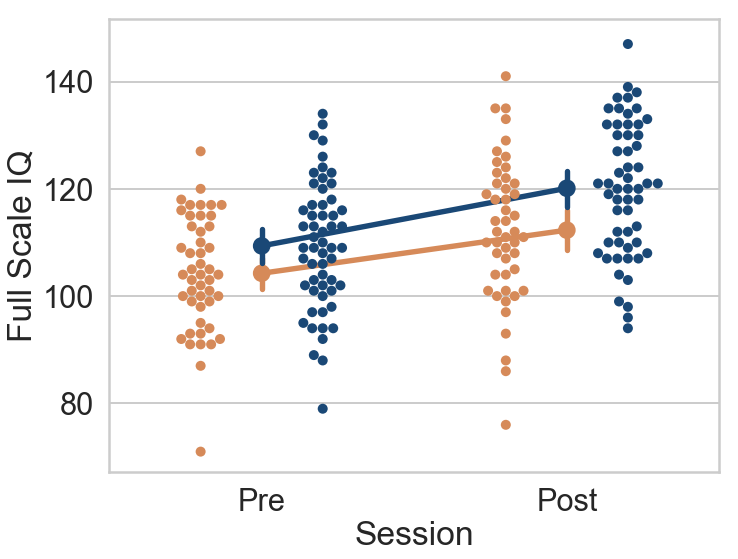

In [34]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=1.5)
mksz = 10
k = sns.swarmplot(x='Session', y='Full Scale IQ', hue='Sex', data=fs_long, palette=crayons_d, dodge=True, ax=ax, size=mksz)
k.get_legend().set_visible(False)

j = sns.pointplot(x='Session', y='Full Scale IQ', hue='Sex', data=fs_long, ax=ax, palette=crayons_d)
j.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-IQ.png', dpi=300)

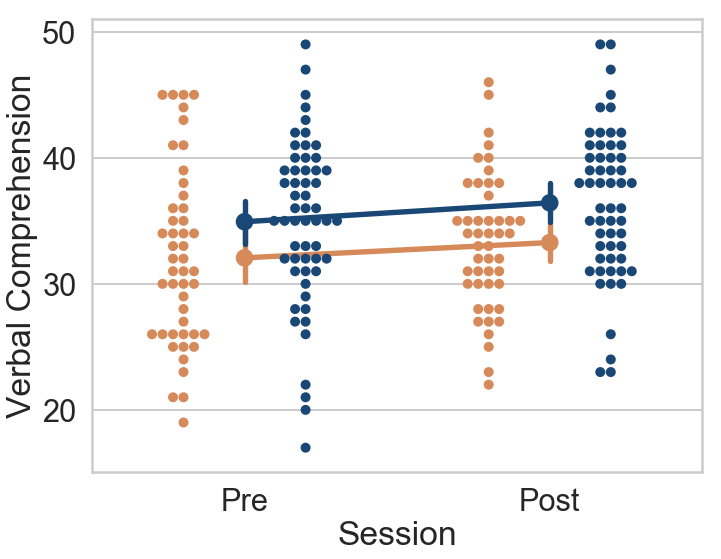

In [35]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=1.5)
mksz = 10
k = sns.pointplot(x='Session', y='Verbal Comprehension', hue='Sex', data=vc_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Verbal Comprehension', hue='Sex', data=vc_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-vcIQ.png', dpi=300)

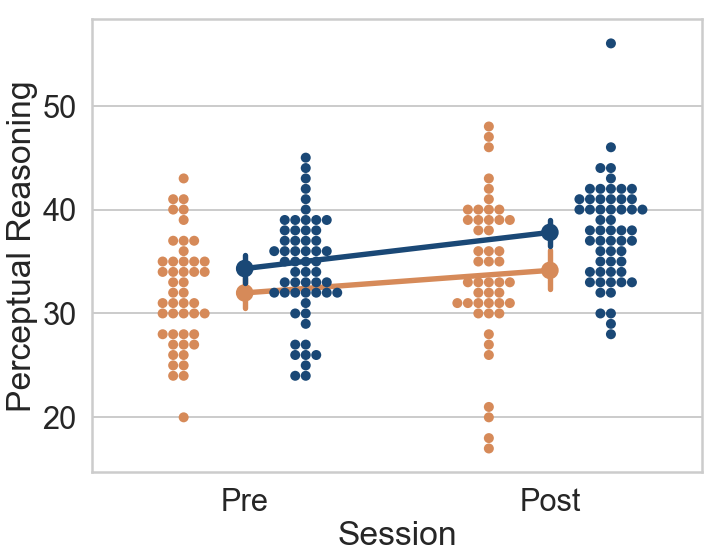

In [36]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=1.5)
mksz = 10
k = sns.pointplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-prIQ.png', dpi=300)

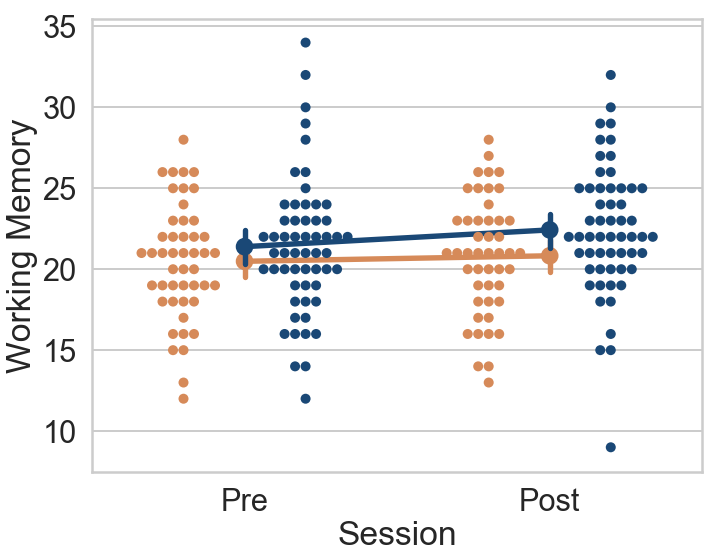

In [37]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=1.5)
mksz = 10
k = sns.pointplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-wmIQ.png', dpi=300)

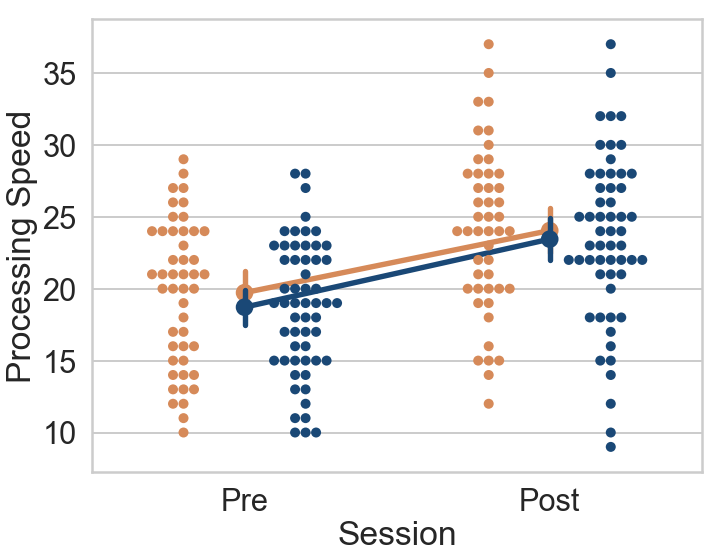

In [38]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
mksz = 10
plt.tight_layout(pad=1.5)
k = sns.pointplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-psIQ.png', dpi=300)

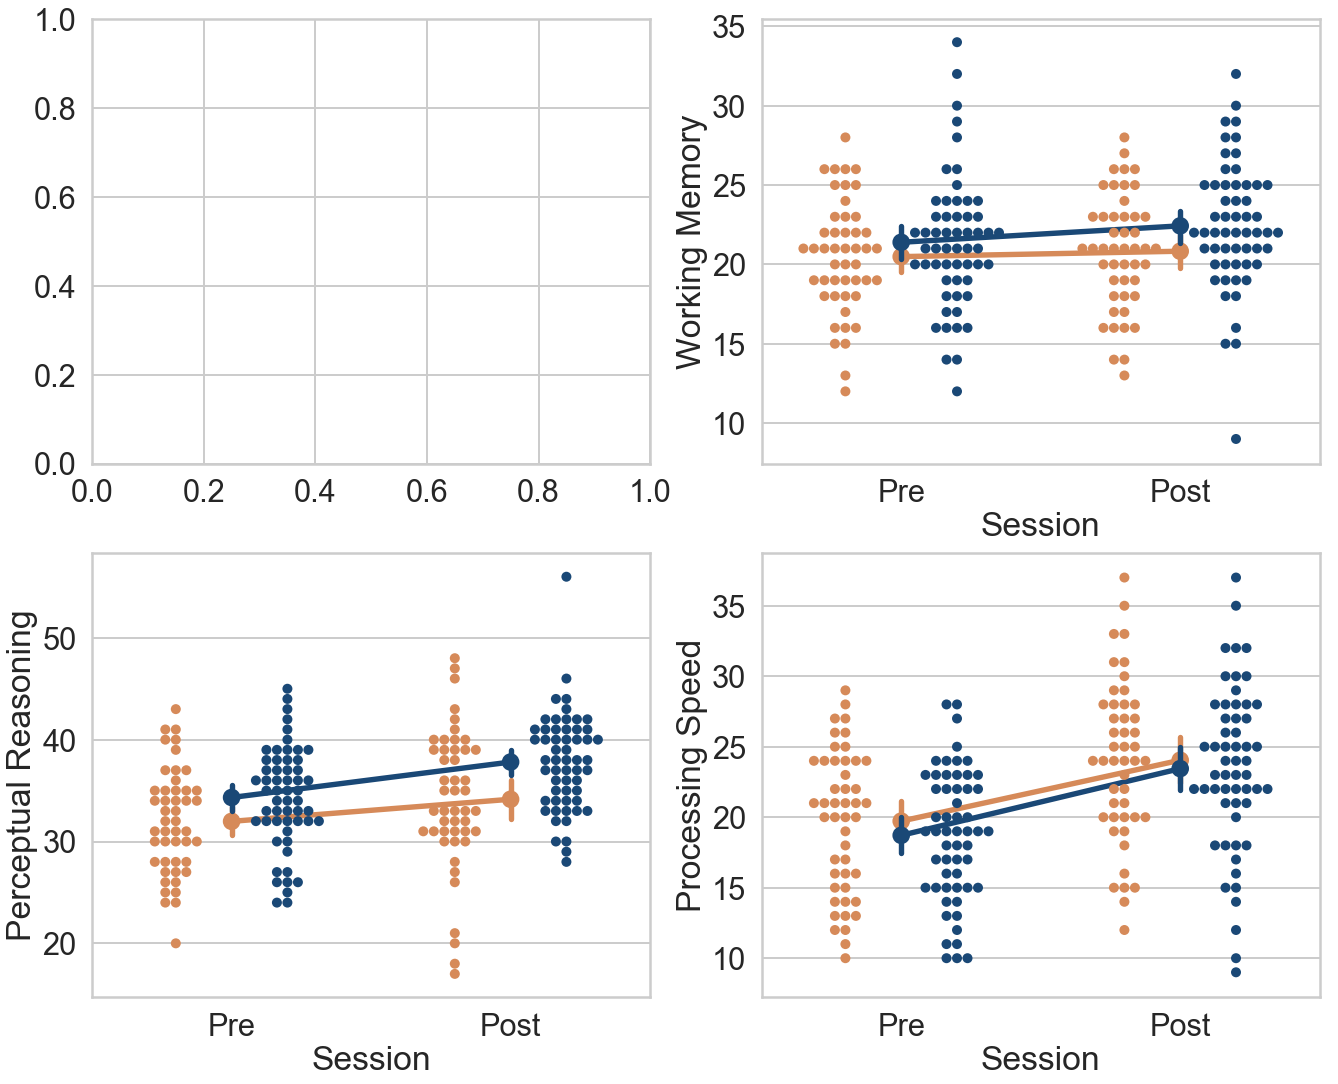

In [39]:
fig,ax = plt.subplots(ncols=2, nrows=2, figsize=(22, 18), sharex=False, sharey=False, squeeze=True)
mksz = 10


sns.pointplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, palette=crayons_d, ax=ax[1][0], size=mksz)
sns.pointplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, palette=crayons_d, ax=ax[0][1], size=mksz)
sns.pointplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, palette=crayons_d, ax=ax[1][1], size=mksz)


h = sns.swarmplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, 
              palette=crayons_d, ax=ax[1][0], size=mksz, dodge=True)
h.get_legend().set_visible(False)
i = sns.swarmplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, 
              palette=crayons_d, ax=ax[0][1], size=mksz, dodge=True)
i.get_legend().set_visible(False)
j = sns.swarmplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, 
              palette=crayons_d, ax=ax[1][1], size=mksz, dodge=True)
j.get_legend().set_visible(False)


fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-IQ-subscores.png', dpi=300)

## Does IQ facilitate learning?
Is pre-instruction IQ significantly related to academic performance or change in physics knowledge/reasoning?

## Does IQ reflect learning?
Is the change in IQ over the duration of the course related to academic performance or change in physics knowledge/reasoning?

In [40]:
sessions.append('delta')

In [41]:
liji_sidak_mc(all_df[pre_iq], 0.05)

Number of effective comparisons: 3.497354086558783
Critical value of 0.050 becomes 0.014559 after corrections


(0.01455928781771576, 3.497354086558783)

In [42]:
liji_sidak_mc(all_df[post_iq], 0.05)

Number of effective comparisons: 3.22242023152536
Critical value of 0.050 becomes 0.015792 after corrections


(0.015791614477792426, 3.22242023152536)

In [43]:
liji_sidak_mc(all_df[['delta Full Scale IQ', 'delta Verbal Comprehension', 'delta Working Memory',
                      'delta Processing Speed', 'delta Perceptual Reasoning']], 0.05)

Number of effective comparisons: 3.653235898335174
Critical value of 0.050 becomes 0.013942 after corrections


(0.013942401530258053, 3.653235898335174)

In [44]:
outcomes = ['Phy48Grade', 'Mean Physics Retrieval Accuracy Post', 'Post Mean FCI Accuracy', 
            'delta Physics Retrieval Accuracy', 'delta FCI Accuracy']

In [45]:
#let's use regressions instead
index = pd.MultiIndex.from_product((sessions, iqs))
female_iqXgrade = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)', 
                                                     'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval'])
male_iqXgrade = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)',
                                                   'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval'])
for outcome in outcomes:
    for iq_meas in iqs:
        y = df_f[outcome]
        x = df_f[['{0}_1'.format(iq_meas), '{0}_1XClass'.format(iq_meas), 'AgeOnScanDate', 'Mod', 'Strt.Level']]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_pre_iq = reg1.fit()
        female_iqXgrade.at[('pre', iq_meas), 'F-statistic'] = grade_on_pre_iq.fvalue
        female_iqXgrade.at[('pre', iq_meas), 'Prob (F-statistic)'] = grade_on_pre_iq.f_pvalue
        female_iqXgrade.at[('pre', iq_meas), 'AIC'] = grade_on_pre_iq.aic
        female_iqXgrade.at[('pre', iq_meas), 'BIC'] = grade_on_pre_iq.bic
        female_iqXgrade.at[('pre', iq_meas), 'IQ_pval'] = grade_on_pre_iq.pvalues[1]
        female_iqXgrade.at[('pre', iq_meas), 'IQXClass_pval'] = grade_on_pre_iq.pvalues[2]
        #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())

        x = df_f[['{0}_2'.format(iq_meas), '{0}_2XClass'.format(iq_meas), 'AgeOnScanDate', 'Mod', 'Strt.Level']]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_post_iq = reg1.fit()
        female_iqXgrade.at[('post', iq_meas), 'F-statistic'] = grade_on_post_iq.fvalue
        female_iqXgrade.at[('post', iq_meas), 'Prob (F-statistic)'] = grade_on_post_iq.f_pvalue
        female_iqXgrade.at[('post', iq_meas), 'AIC'] = grade_on_post_iq.aic
        female_iqXgrade.at[('post', iq_meas), 'BIC'] = grade_on_post_iq.bic
        female_iqXgrade.at[('post', iq_meas), 'IQ_pval'] = grade_on_post_iq.pvalues[1]
        female_iqXgrade.at[('post', iq_meas), 'IQXClass_pval'] = grade_on_post_iq.pvalues[2]
        #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())
        if iq_meas == 'Full Scale IQ':
            x = df_f[['delta {0}'.format(iq_meas), 'delta {0}XClass'.format(iq_meas), 
                           'AgeOnScanDate', 'Mod', 'Strt.Level']]
        else:
            x = df_f[['delta {0}'.format(iq_meas[:-4]), 'delta {0}XClass'.format(iq_meas), 
                           'AgeOnScanDate', 'Mod', 'Strt.Level']]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_delta_iq = reg1.fit()
        female_iqXgrade.at[('delta', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
        female_iqXgrade.at[('delta', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
        female_iqXgrade.at[('delta', iq_meas), 'AIC'] = grade_on_delta_iq.aic
        female_iqXgrade.at[('delta', iq_meas), 'BIC'] = grade_on_delta_iq.bic
        female_iqXgrade.at[('delta', iq_meas), 'IQ_pval'] = grade_on_delta_iq.pvalues[1]
        female_iqXgrade.at[('delta', iq_meas), 'IQXClass_pval'] = grade_on_delta_iq.pvalues[2]
        
        y = df_m[outcome]
        x = df_m[['{0}_1'.format(iq_meas), '{0}_1XClass'.format(iq_meas), 'AgeOnScanDate', 'Mod', 'Strt.Level']]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_pre_iq = reg1.fit()
        male_iqXgrade.at[('pre', iq_meas), 'F-statistic'] = grade_on_pre_iq.fvalue
        male_iqXgrade.at[('pre', iq_meas), 'Prob (F-statistic)'] = grade_on_pre_iq.f_pvalue
        male_iqXgrade.at[('pre', iq_meas), 'AIC'] = grade_on_pre_iq.aic
        male_iqXgrade.at[('pre', iq_meas), 'BIC'] = grade_on_pre_iq.bic
        male_iqXgrade.at[('pre', iq_meas), 'IQ_pval'] = grade_on_pre_iq.pvalues[1]
        male_iqXgrade.at[('pre', iq_meas), 'IQXClass_pval'] = grade_on_pre_iq.pvalues[2]
        #print('Course grade regressed on pre IQ, male students\n', grade_on_iq.summary())

        x = df_m[['{0}_2'.format(iq_meas), '{0}_2XClass'.format(iq_meas), 'AgeOnScanDate', 'Mod', 'Strt.Level']]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_post_iq = reg1.fit()
        male_iqXgrade.at[('post', iq_meas), 'F-statistic'] = grade_on_post_iq.fvalue
        male_iqXgrade.at[('post', iq_meas), 'Prob (F-statistic)'] = grade_on_post_iq.f_pvalue
        male_iqXgrade.at[('post', iq_meas), 'AIC'] = grade_on_post_iq.aic
        male_iqXgrade.at[('post', iq_meas), 'BIC'] = grade_on_post_iq.bic
        male_iqXgrade.at[('post', iq_meas), 'IQ_pval'] = grade_on_post_iq.pvalues[1]
        male_iqXgrade.at[('post', iq_meas), 'IQXClass_pval'] = grade_on_post_iq.pvalues[2]
        #print('Course grade regressed on post IQ, male students\n', grade_on_iq.summary())
        if iq_meas == 'Full Scale IQ':
            x = df_m[['delta {0}'.format(iq_meas), 'delta {0}XClass'.format(iq_meas), 
                           'AgeOnScanDate', 'Mod', 'Strt.Level']]
        else:
            x = df_m[['delta {0}'.format(iq_meas[:-4]), 'delta {0}XClass'.format(iq_meas), 
                           'AgeOnScanDate', 'Mod', 'Strt.Level']]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_delta_iq = reg1.fit()
        male_iqXgrade.at[('delta', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
        male_iqXgrade.at[('delta', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
        male_iqXgrade.at[('delta', iq_meas), 'AIC'] = grade_on_delta_iq.aic
        male_iqXgrade.at[('delta', iq_meas), 'BIC'] = grade_on_delta_iq.bic
        male_iqXgrade.at[('delta', iq_meas), 'IQ_pval'] = grade_on_delta_iq.pvalues[1]
        male_iqXgrade.at[('delta', iq_meas), 'IQXClass_pval'] = grade_on_delta_iq.pvalues[2]
        #print('Course grade regressed on delta IQ, female students\n', grade_on_iq.summary())
    female_iqXgrade.to_csv(join(data_dir, 'iqX{0}_female.csv'.format(outcome)))
    male_iqXgrade.to_csv(join(data_dir, 'iqX{0}_male.csv'.format(outcome)))

In [46]:
index = pd.MultiIndex.from_product((sessions, iqs))
female_iqXgrade = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)', 
                                                     'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval'])
male_iqXgrade = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)',
                                                   'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval'])
for outcome in outcomes:
    for iq_meas in iqs:
        y = df_f[outcome]
        x = df_f[['{0}_1'.format(iq_meas), '{0}_1XClass'.format(iq_meas), 'AgeOnScanDate', 'Strt.Level']]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_pre_iq = reg1.fit()
        female_iqXgrade.at[('pre', iq_meas), 'F-statistic'] = grade_on_pre_iq.fvalue
        female_iqXgrade.at[('pre', iq_meas), 'Prob (F-statistic)'] = grade_on_pre_iq.f_pvalue
        female_iqXgrade.at[('pre', iq_meas), 'AIC'] = grade_on_pre_iq.aic
        female_iqXgrade.at[('pre', iq_meas), 'BIC'] = grade_on_pre_iq.bic
        female_iqXgrade.at[('pre', iq_meas), 'IQ_pval'] = grade_on_pre_iq.pvalues[1]
        female_iqXgrade.at[('pre', iq_meas), 'IQXClass_pval'] = grade_on_pre_iq.pvalues[2]
        #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())

        x = df_f[['{0}_2'.format(iq_meas), '{0}_2XClass'.format(iq_meas), 'AgeOnScanDate', 'Strt.Level']]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_post_iq = reg1.fit()
        female_iqXgrade.at[('post', iq_meas), 'F-statistic'] = grade_on_post_iq.fvalue
        female_iqXgrade.at[('post', iq_meas), 'Prob (F-statistic)'] = grade_on_post_iq.f_pvalue
        female_iqXgrade.at[('post', iq_meas), 'AIC'] = grade_on_post_iq.aic
        female_iqXgrade.at[('post', iq_meas), 'BIC'] = grade_on_post_iq.bic
        female_iqXgrade.at[('post', iq_meas), 'IQ_pval'] = grade_on_post_iq.pvalues[1]
        female_iqXgrade.at[('post', iq_meas), 'IQXClass_pval'] = grade_on_post_iq.pvalues[2]
        #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())
        if iq_meas == 'Full Scale IQ':
            x = df_f[['delta {0}'.format(iq_meas), 'delta {0}XClass'.format(iq_meas), 
                           'AgeOnScanDate', 'Strt.Level']]
        else:
            x = df_f[['delta {0}'.format(iq_meas[:-4]), 'delta {0}XClass'.format(iq_meas), 
                           'AgeOnScanDate', 'Strt.Level']]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_delta_iq = reg1.fit()
        female_iqXgrade.at[('delta', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
        female_iqXgrade.at[('delta', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
        female_iqXgrade.at[('delta', iq_meas), 'AIC'] = grade_on_delta_iq.aic
        female_iqXgrade.at[('delta', iq_meas), 'BIC'] = grade_on_delta_iq.bic
        female_iqXgrade.at[('delta', iq_meas), 'IQ_pval'] = grade_on_delta_iq.pvalues[1]
        female_iqXgrade.at[('delta', iq_meas), 'IQXClass_pval'] = grade_on_delta_iq.pvalues[2]
        
        y = df_m[outcome]
        x = df_m[['{0}_1'.format(iq_meas), '{0}_1XClass'.format(iq_meas), 'AgeOnScanDate', 'Strt.Level']]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_pre_iq = reg1.fit()
        male_iqXgrade.at[('pre', iq_meas), 'F-statistic'] = grade_on_pre_iq.fvalue
        male_iqXgrade.at[('pre', iq_meas), 'Prob (F-statistic)'] = grade_on_pre_iq.f_pvalue
        male_iqXgrade.at[('pre', iq_meas), 'AIC'] = grade_on_pre_iq.aic
        male_iqXgrade.at[('pre', iq_meas), 'BIC'] = grade_on_pre_iq.bic
        male_iqXgrade.at[('pre', iq_meas), 'IQ_pval'] = grade_on_pre_iq.pvalues[1]
        male_iqXgrade.at[('pre', iq_meas), 'IQXClass_pval'] = grade_on_pre_iq.pvalues[2]
        #print('Course grade regressed on pre IQ, male students\n', grade_on_iq.summary())

        x = df_m[['{0}_2'.format(iq_meas), '{0}_2XClass'.format(iq_meas), 'AgeOnScanDate', 'Strt.Level']]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_post_iq = reg1.fit()
        male_iqXgrade.at[('post', iq_meas), 'F-statistic'] = grade_on_post_iq.fvalue
        male_iqXgrade.at[('post', iq_meas), 'Prob (F-statistic)'] = grade_on_post_iq.f_pvalue
        male_iqXgrade.at[('post', iq_meas), 'AIC'] = grade_on_post_iq.aic
        male_iqXgrade.at[('post', iq_meas), 'BIC'] = grade_on_post_iq.bic
        male_iqXgrade.at[('post', iq_meas), 'IQ_pval'] = grade_on_post_iq.pvalues[1]
        male_iqXgrade.at[('post', iq_meas), 'IQXClass_pval'] = grade_on_post_iq.pvalues[2]
        #print('Course grade regressed on post IQ, male students\n', grade_on_iq.summary())
        if iq_meas == 'Full Scale IQ':
            x = df_m[['delta {0}'.format(iq_meas), 'delta {0}XClass'.format(iq_meas), 
                           'AgeOnScanDate', 'Strt.Level']]
        else:
            x = df_m[['delta {0}'.format(iq_meas[:-4]), 'delta {0}XClass'.format(iq_meas), 
                           'AgeOnScanDate', 'Strt.Level']]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_delta_iq = reg1.fit()
        male_iqXgrade.at[('delta', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
        male_iqXgrade.at[('delta', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
        male_iqXgrade.at[('delta', iq_meas), 'AIC'] = grade_on_delta_iq.aic
        male_iqXgrade.at[('delta', iq_meas), 'BIC'] = grade_on_delta_iq.bic
        male_iqXgrade.at[('delta', iq_meas), 'IQ_pval'] = grade_on_delta_iq.pvalues[1]
        male_iqXgrade.at[('delta', iq_meas), 'IQXClass_pval'] = grade_on_delta_iq.pvalues[2]
        #print('Course grade regressed on delta IQ, female students\n', grade_on_iq.summary())
    female_iqXgrade.to_csv(join(data_dir, 'iqX{0}_female-noclass.csv'.format(outcome)))
    male_iqXgrade.to_csv(join(data_dir, 'iqX{0}_male-noclass.csv'.format(outcome)))

In [47]:
liji_sidak_mc(rsgt_df, 0.05)

Number of effective comparisons: 2.437683835810727
Critical value of 0.050 becomes 0.020822 after corrections


(0.020821981453361005, 2.437683835810727)

## Is IQ related to global brain organization?
pre-instruction IQ and efficiency, characteristic path length, and modularity. same for post. how does this relationship change?

## Let's run some regressions, to get better answers
1. Need to check for collinearity, using correlations
2. Run some regressions for change in IQ (does it vary with respect to class type, age, year in school?)
3. What are the relationships between IQ and academic success, controlling for class type, age, year in school?
4. What are the relationships between IQ and brain topologcy, controlling for (a) age, gender, head size, avg FD? and (b) class type, year in school?

In [48]:
dumb = pd.get_dummies(all_df['Gender'])
all_df['F'] = dumb['F']

In [49]:
vars_of_interest = ['AgeOnScanDate', 'Phy48Grade', 'GPA.PreSem',
       'Mean Physics Retrieval Accuracy Pre', 'Mean Correct RT Pre',
       'Mean Physics Retrieval Accuracy Post',
       'Mean Correct RT Post', 'F',
       'Pre Mean FCI Accuracy', 'Post Mean FCI Accuracy', 'shen eff pre',
       'shen eff post', 'shen cpl pre', 'shen cpl post', 'shen mod pre',
       'shen mod post', 'crad eff pre', 'crad eff post', 'crad cpl pre',
       'crad cpl post', 'crad mod pre', 'crad mod post',
       'Strt.Level', 'Verbal Comprehension Sum_1',
       'Perceptual Reasoning Sum_1', 'Working Memory Sum_1',
       'Processing Speed Sum_1', 'Full Scale IQ_1',
       'Verbal Comprehension Sum_2', 'Perceptual Reasoning Sum_2',
       'Working Memory Sum_2', 'Processing Speed Sum_2', 'Full Scale IQ_2',
       'delta Physics Retrieval Accuracy', 'delta FCI Accuracy',
       'delta Verbal Comprehension', 'delta Perceptual Reasoning',
       'delta Working Memory', 'delta Processing Speed', 'delta Full Scale IQ',
       'Mod', 'normalized head size']

In [50]:
#check for collinearity
index = pd.MultiIndex.from_product([vars_of_interest, vars_of_interest], names=['key1', 'key2'])
corr_df = pd.DataFrame(index=index, columns=['spearman r', 'p(r)'])
for key1 in vars_of_interest:
    for key2 in vars_of_interest:
        corr = spearmanr(all_df[key1].values, all_df[key2].values, nan_policy='omit')
        corr_df.at[(key1, key2), 'spearman r'] = corr[0]
        corr_df.at[(key1, key2), 'p(r)'] = corr[1]

In [51]:
correlation_measure = 'spearman'
mc_corr = liji_sidak_mc(all_df[vars_of_interest], 0.05)
calculate_pvalues(all_df[vars_of_interest], correlation_measure).to_csv(join(data_dir, '{0}r_pvals-{1}.csv'.format(correlation_measure, np.round(mc_corr[0], 5))))


Number of effective comparisons: 19.796107002270638
Critical value of 0.050 becomes 0.002588 after corrections


## Now we regress brain stuff on IQ
And control for age, time in school, sex, head size

In [52]:
outcomes = ['shen eff pre', 'shen eff post', 'shen cpl pre', 
            'shen cpl post', 'shen mod pre', 'shen mod post', 
            'crad eff pre', 'crad eff post', 'crad cpl pre',
            'crad cpl post', 'crad mod pre', 'crad mod post',
            'delta mod shen', 'delta cpl shen', 'delta eff shen',
            'delta mod crad', 'delta cpl crad', 'delta eff crad']
covariates = ['AgeOnScanDate', 'Mod', 'Strt.Level', 'normalized head size']

In [53]:
index = pd.MultiIndex.from_product((sessions, iqs))
brainXIQ_df = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)', 
                                                     'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval'])
all_outcome_mc,_ = liji_sidak_mc(all_df[outcomes], 0.05)
for outcome in outcomes:
    for iq_meas in iqs:
        y = all_df[outcome]
        x = all_df[['{0}_1'.format(iq_meas), '{0}_1XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_pre_iq = reg1.fit()
        brainXIQ_df.at[('pre', iq_meas), 'F-statistic'] = brain_on_pre_iq.fvalue
        brainXIQ_df.at[('pre', iq_meas), 'Prob (F-statistic)'] = brain_on_pre_iq.f_pvalue
        brainXIQ_df.at[('pre', iq_meas), 'AIC'] = brain_on_pre_iq.aic
        brainXIQ_df.at[('pre', iq_meas), 'BIC'] = brain_on_pre_iq.bic
        brainXIQ_df.at[('pre', iq_meas), 'IQ_pval'] = brain_on_pre_iq.pvalues[1]
        brainXIQ_df.at[('pre', iq_meas), 'IQXClass_pval'] = brain_on_pre_iq.pvalues[2]
        if brain_on_pre_iq.f_pvalue < all_outcome_mc:
            print('all students', outcome, iq_meas, 'p(model) =', brain_on_pre_iq.f_pvalue, 
                  'p(iq_pre) =', brain_on_pre_iq.pvalues[1], 'p(iqXclass) =', brain_on_pre_iq.pvalues[2])
        #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())

        x = all_df[['{0}_2'.format(iq_meas), '{0}_2XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_post_iq = reg1.fit()
        brainXIQ_df.at[('post', iq_meas), 'F-statistic'] = brain_on_post_iq.fvalue
        brainXIQ_df.at[('post', iq_meas), 'Prob (F-statistic)'] = brain_on_post_iq.f_pvalue
        brainXIQ_df.at[('post', iq_meas), 'AIC'] = brain_on_post_iq.aic
        brainXIQ_df.at[('post', iq_meas), 'BIC'] = brain_on_post_iq.bic
        brainXIQ_df.at[('post', iq_meas), 'IQ_pval'] = brain_on_post_iq.pvalues[1]
        brainXIQ_df.at[('post', iq_meas), 'IQXClass_pval'] = brain_on_post_iq.pvalues[2]
        if brain_on_post_iq.f_pvalue < all_outcome_mc:
            print('all students', outcome, iq_meas, 'p(model) =', brain_on_post_iq.f_pvalue, 
                  'p(iq_post) =', brain_on_post_iq.pvalues[1], 'p(iqXclass) =', brain_on_post_iq.pvalues[2])
        #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())
        if iq_meas == 'Full Scale IQ':
            x = all_df[['delta {0}'.format(iq_meas), 'delta {0}XClass'.format(iq_meas)] + covariates]
        else:
            x = all_df[['delta {0}'.format(iq_meas[:-4]), 'delta {0}XClass'.format(iq_meas)] + covariates]
        
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_delta_iq = reg1.fit()
        brainXIQ_df.at[('delta', iq_meas), 'F-statistic'] = brain_on_delta_iq.fvalue
        brainXIQ_df.at[('delta', iq_meas), 'Prob (F-statistic)'] = brain_on_delta_iq.f_pvalue
        brainXIQ_df.at[('delta', iq_meas), 'AIC'] = brain_on_delta_iq.aic
        brainXIQ_df.at[('delta', iq_meas), 'BIC'] = brain_on_delta_iq.bic
        brainXIQ_df.at[('delta', iq_meas), 'IQ_pval'] = brain_on_delta_iq.pvalues[1]
        brainXIQ_df.at[('delta', iq_meas), 'IQXClass_pval'] = brain_on_delta_iq.pvalues[2]
        if brain_on_delta_iq.f_pvalue < all_outcome_mc:
            print('all students', outcome, iq_meas, 'p(model) =', brain_on_delta_iq.f_pvalue, 
                  'p(iq_delta) =', brain_on_delta_iq.pvalues[1], 'p(iqXclass) =', brain_on_delta_iq.pvalues[2])
    brainXIQ_df.to_csv(join(data_dir, 'iqX{0}_all.csv'.format(outcome)))

Number of effective comparisons: 4.35806544030898
Critical value of 0.050 becomes 0.011701 after corrections


In [54]:
brainXIQ_df

F-statistic Prob (F-statistic)      AIC  \
pre   Verbal Comprehension Sum    0.613552           0.718925 -446.783   
      Perceptual Reasoning Sum    0.543219           0.774052 -446.346   
      Working Memory Sum          0.744668           0.615106 -447.593   
      Processing Speed Sum         1.23331           0.296489 -450.557   
      Full Scale IQ               0.843813           0.539373 -448.202   
post  Verbal Comprehension Sum    0.695075           0.654163 -447.288   
      Perceptual Reasoning Sum    0.525477           0.787663 -446.235   
      Working Memory Sum            1.3714            0.23434 -451.379   
      Processing Speed Sum        0.661452           0.680863  -447.08   
      Full Scale IQ               0.891665           0.504424 -448.494   
delta Verbal Comprehension Sum    0.964908           0.453436  -448.94   
      Perceptual Reasoning Sum    0.594315           0.734138 -446.664   
      Working Memory Sum          0.704756           0.646501 -447.347   
      Processing Speed Sum        0.640771            0.69731 -446.952   
      Full Scale IQ               0.576834           0.747891 -446.555   

                                    BIC    IQ_pval IQXClass_pval  
pre   Verbal Comprehension Sum -428.547   0.559996      0.448467  
      Perceptual Reasoning Sum -428.109   0.841242      0.715759  
      Working Memory Sum       -429.357   0.633919      0.934878  
      Processing Speed Sum     -432.321  0.0494437     0.0942046  
      Full Scale IQ            -429.966   0.561382      0.903154  
post  Verbal Comprehension Sum -429.051   0.419208      0.599346  
      Perceptual Reasoning Sum -427.999   0.676096      0.763207  
      Working Memory Sum       -433.143   0.592457      0.856441  
      Processing Speed Sum     -428.844     0.3351       0.31171  
      Full Scale IQ            -430.258   0.243913      0.437323  
delta Verbal Comprehension Sum -430.704  0.0976088       0.11655  
      Perceptual Reasoning Sum -428.427   0.455036      0.424648  
      Working Memory Sum       -429.111   0.810154      0.560772  
      Processing Speed Sum     -428.716   0.515516      0.683156  
      Full Scale IQ            -428.319   0.486662      0.463375

## Brain organization and IQ at pre and post

In [55]:
#let's use regressions instead
index = pd.MultiIndex.from_product((sessions, iqs))
female_iqXgrade = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)', 
                                                     'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval'])
male_iqXgrade = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)',
                                                   'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval'])

female_mc_alpha,_ = liji_sidak_mc(df_f[outcomes], 0.05)
male_mc_alpha,_ = liji_sidak_mc(df_m[outcomes], 0.05)
for outcome in outcomes:
    for iq_meas in iqs:
        y = df_f[outcome]
        x = df_f[['{0}_1'.format(iq_meas), '{0}_1XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_pre_iq = reg1.fit()
        female_iqXgrade.at[('pre', iq_meas), 'F-statistic'] = grade_on_pre_iq.fvalue
        female_iqXgrade.at[('pre', iq_meas), 'Prob (F-statistic)'] = grade_on_pre_iq.f_pvalue
        if grade_on_pre_iq.f_pvalue < female_mc_alpha:
            print('f', outcome, iq_meas, 'p(model) =', grade_on_pre_iq.f_pvalue, 
                  'p(iq_pre) =', grade_on_pre_iq.pvalues[1], 'p(iqXclass) =', grade_on_pre_iq.pvalues[2])
        female_iqXgrade.at[('pre', iq_meas), 'AIC'] = grade_on_pre_iq.aic
        female_iqXgrade.at[('pre', iq_meas), 'BIC'] = grade_on_pre_iq.bic
        female_iqXgrade.at[('pre', iq_meas), 'IQ_pval'] = grade_on_pre_iq.pvalues[1] 
        female_iqXgrade.at[('pre', iq_meas), 'IQXClass_pval'] = grade_on_pre_iq.pvalues[2]
        #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())

        x = df_f[['{0}_2'.format(iq_meas), '{0}_2XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_post_iq = reg1.fit()
        female_iqXgrade.at[('post', iq_meas), 'F-statistic'] = grade_on_post_iq.fvalue
        female_iqXgrade.at[('post', iq_meas), 'Prob (F-statistic)'] = grade_on_post_iq.f_pvalue
        if grade_on_post_iq.f_pvalue < female_mc_alpha:
            print('f', outcome, iq_meas, 'p(model) =', grade_on_post_iq.f_pvalue, 
                  'p(iq_post) =', grade_on_post_iq.pvalues[1], 'p(iqXclass) =', grade_on_post_iq.pvalues[2])
        female_iqXgrade.at[('post', iq_meas), 'AIC'] = grade_on_post_iq.aic
        female_iqXgrade.at[('post', iq_meas), 'BIC'] = grade_on_post_iq.bic
        female_iqXgrade.at[('post', iq_meas), 'IQ_pval'] = grade_on_post_iq.pvalues[1]
        female_iqXgrade.at[('post', iq_meas), 'IQXClass_pval'] = grade_on_post_iq.pvalues[2]
        #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())
        if iq_meas == 'Full Scale IQ':
            x = df_f[['delta {0}'.format(iq_meas), 'delta {0}XClass'.format(iq_meas)] + covariates]
        else:
            x = df_f[['delta {0}'.format(iq_meas[:-4]), 'delta {0}XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_delta_iq = reg1.fit()
        female_iqXgrade.at[('delta', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
        female_iqXgrade.at[('delta', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
        female_iqXgrade.at[('delta', iq_meas), 'AIC'] = grade_on_delta_iq.aic
        female_iqXgrade.at[('delta', iq_meas), 'BIC'] = grade_on_delta_iq.bic
        female_iqXgrade.at[('delta', iq_meas), 'IQ_pval'] = grade_on_delta_iq.pvalues[1]
        female_iqXgrade.at[('delta', iq_meas), 'IQXClass_pval'] = grade_on_delta_iq.pvalues[2]
        if grade_on_delta_iq.f_pvalue < female_mc_alpha:
            print('f', outcome, iq_meas, 'p(model) =', grade_on_delta_iq.f_pvalue, 
                  'p(iq_delta) =', grade_on_delta_iq.pvalues[1], 'p(iqXclass) =', grade_on_delta_iq.pvalues[2])
        
        y = df_m[outcome]
        x = df_m[['{0}_1'.format(iq_meas), '{0}_1XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_pre_iq = reg1.fit()
        male_iqXgrade.at[('pre', iq_meas), 'F-statistic'] = grade_on_pre_iq.fvalue
        male_iqXgrade.at[('pre', iq_meas), 'Prob (F-statistic)'] = grade_on_pre_iq.f_pvalue
        male_iqXgrade.at[('pre', iq_meas), 'AIC'] = grade_on_pre_iq.aic
        male_iqXgrade.at[('pre', iq_meas), 'BIC'] = grade_on_pre_iq.bic
        male_iqXgrade.at[('pre', iq_meas), 'IQ_pval'] = grade_on_pre_iq.pvalues[1]
        male_iqXgrade.at[('pre', iq_meas), 'IQXClass_pval'] = grade_on_pre_iq.pvalues[2]
        #print('Course grade regressed on pre IQ, male students\n', grade_on_iq.summary())
        if grade_on_pre_iq.f_pvalue < male_mc_alpha:
            print('m', outcome, iq_meas, 'p(model) =', grade_on_pre_iq.f_pvalue, 
                  'p(iq_pre) =', grade_on_pre_iq.pvalues[1], 'p(iqXclass) =', grade_on_pre_iq.pvalues[2])

        x = df_m[['{0}_2'.format(iq_meas), '{0}_2XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_post_iq = reg1.fit()
        male_iqXgrade.at[('post', iq_meas), 'F-statistic'] = grade_on_post_iq.fvalue
        male_iqXgrade.at[('post', iq_meas), 'Prob (F-statistic)'] = grade_on_post_iq.f_pvalue
        male_iqXgrade.at[('post', iq_meas), 'AIC'] = grade_on_post_iq.aic
        male_iqXgrade.at[('post', iq_meas), 'BIC'] = grade_on_post_iq.bic
        male_iqXgrade.at[('post', iq_meas), 'IQ_pval'] = grade_on_post_iq.pvalues[1]
        male_iqXgrade.at[('post', iq_meas), 'IQXClass_pval'] = grade_on_post_iq.pvalues[2]
        if grade_on_post_iq.f_pvalue < male_mc_alpha:
            print('m', outcome, iq_meas, 'p(model) =', grade_on_post_iq.f_pvalue, 
                  'p(iq_post) =', grade_on_post_iq.pvalues[1], 'p(iqXclass) =', grade_on_post_iq.pvalues[2])
        #print('Course grade regressed on post IQ, male students\n', grade_on_iq.summary())
        if iq_meas == 'Full Scale IQ':
            x = df_m[['delta {0}'.format(iq_meas), 'delta {0}XClass'.format(iq_meas)] + covariates]
        else:
            x = df_m[['delta {0}'.format(iq_meas[:-4]), 'delta {0}XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_delta_iq = reg1.fit()
        male_iqXgrade.at[('delta', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
        male_iqXgrade.at[('delta', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
        male_iqXgrade.at[('delta', iq_meas), 'AIC'] = grade_on_delta_iq.aic
        male_iqXgrade.at[('delta', iq_meas), 'BIC'] = grade_on_delta_iq.bic
        male_iqXgrade.at[('delta', iq_meas), 'IQ_pval'] = grade_on_delta_iq.pvalues[1]
        male_iqXgrade.at[('delta', iq_meas), 'IQXClass_pval'] = grade_on_delta_iq.pvalues[2]
        #print('Course grade regressed on delta IQ, female students\n', grade_on_iq.summary())
        if grade_on_delta_iq.f_pvalue < male_mc_alpha:
            print('m', outcome, iq_meas, 'p(model) =', grade_on_delta_iq.f_pvalue, 
                  'p(iq_delta) =', grade_on_delta_iq.pvalues[1], 'p(iqXclass) =', grade_on_delta_iq.pvalues[2])
    female_iqXgrade.to_csv(join(data_dir, 'iqX{0}_female.csv'.format(outcome)))
    male_iqXgrade.to_csv(join(data_dir, 'iqX{0}_male.csv'.format(outcome)))

Number of effective comparisons: 3.8959524732813784
Critical value of 0.050 becomes 0.013080 after corrections
Number of effective comparisons: 4.407131034443862
Critical value of 0.050 becomes 0.011571 after corrections
f crad mod post Verbal Comprehension Sum p(model) = 0.0016938023886058206 p(iq_delta) = 0.10984610700702732 p(iqXclass) = 0.9713494617625397


In [56]:
task_df = pd.read_csv(join(data_dir, 'physics-learning-tasks_graphtheory_shen+craddock_2019-05-30.csv'), index_col=0, header=0)

In [57]:
retr_df = task_df[task_df['task'] == 'retr']
retr_phys_df = retr_df[retr_df['condition'] == 'high-level']
genr_phys_df = retr_df[retr_df['condition'] == 'lower-level']

In [58]:
#physics retrieval measures per session per parcellation
df_pivot = retr_phys_df[retr_phys_df['mask'] == 'shen2015'].reset_index()
shen_eff_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_retr_phys_df.rename({0: 'phys retr shen eff pre', 1: 'phys retr shen eff post'}, axis=1, inplace=True)

shen_cpl_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_retr_phys_df.rename({0: 'phys retr shen cpl pre', 1: 'phys retr shen cpl post'}, axis=1, inplace=True)

shen_mod_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_retr_phys_df.rename({0: 'phys retr shen mod pre', 1: 'phys retr shen mod post'}, axis=1, inplace=True)

df_pivot = retr_phys_df[retr_phys_df['mask'] == 'craddock2012'].reset_index()
crad_eff_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_retr_phys_df.rename({0: 'phys retr crad eff pre', 1: 'phys retr crad eff post'}, axis=1, inplace=True)

crad_cpl_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_retr_phys_df.rename({0: 'phys retr crad cpl pre', 1: 'phys retr crad cpl post'}, axis=1, inplace=True)

crad_mod_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_retr_phys_df.rename({0: 'phys retr crad mod pre', 1: 'phys retr crad mod post'}, axis=1, inplace=True)

#general retrieval measures per session per parcellation
df_pivot = genr_phys_df[genr_phys_df['mask'] == 'shen2015'].reset_index()
shen_eff_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_retr_genr_df.rename({0: 'gen retr shen eff pre', 1: 'gen retr shen eff post'}, axis=1, inplace=True)

shen_cpl_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_retr_genr_df.rename({0: 'gen retr shen cpl pre', 1: 'gen retr shen cpl post'}, axis=1, inplace=True)

shen_mod_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_retr_genr_df.rename({0: 'gen retr shen mod pre', 1: 'gen retr shen mod post'}, axis=1, inplace=True)

df_pivot = genr_phys_df[genr_phys_df['mask'] == 'craddock2012'].reset_index()
crad_eff_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_retr_genr_df.rename({0: 'gen retr crad eff pre', 1: 'gen retr crad eff post'}, axis=1, inplace=True)

crad_cpl_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_retr_genr_df.rename({0: 'gen retr crad cpl pre', 1: 'gen retr crad cpl post'}, axis=1, inplace=True)

crad_mod_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_retr_genr_df.rename({0: 'gen retr crad mod pre', 1: 'gen retr crad mod post'}, axis=1, inplace=True)


In [59]:
reas_df = task_df[task_df['task'] == 'reas']
reas_infr_df = reas_df[reas_df['condition'] == 'high-level']
reas_base_df = reas_df[reas_df['condition'] == 'low-level']

In [60]:
#inference reasoning measures per session per parcellation
df_pivot = reas_infr_df[reas_infr_df['mask'] == 'shen2015'].reset_index()
shen_eff_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_reas_infr_df.rename({0: 'infr reas shen eff pre', 1: 'infr reas shen eff post'}, axis=1, inplace=True)

shen_cpl_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_reas_infr_df.rename({0: 'infr reas shen cpl pre', 1: 'infr reas shen cpl post'}, axis=1, inplace=True)

shen_mod_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_reas_infr_df.rename({0: 'infr reas shen mod pre', 1: 'infr reas shen mod post'}, axis=1, inplace=True)

df_pivot = reas_infr_df[reas_infr_df['mask'] == 'craddock2012'].reset_index()
crad_eff_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_reas_infr_df.rename({0: 'infr reas crad eff pre', 1: 'infr reas crad eff post'}, axis=1, inplace=True)

crad_cpl_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_reas_infr_df.rename({0: 'infr reas crad cpl pre', 1: 'infr reas crad cpl post'}, axis=1, inplace=True)

crad_mod_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_reas_infr_df.rename({0: 'infr reas crad mod pre', 1: 'infr reas crad mod post'}, axis=1, inplace=True)

#base reasoning measures per session per parcellation
df_pivot = reas_base_df[reas_base_df['mask'] == 'shen2015'].reset_index()
shen_eff_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_reas_base_df.rename({0: 'base reas shen eff pre', 1: 'base reas shen eff post'}, axis=1, inplace=True)

shen_cpl_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_reas_base_df.rename({0: 'base reas shen cpl pre', 1: 'base reas shen cpl post'}, axis=1, inplace=True)

shen_mod_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_reas_base_df.rename({0: 'base reas shen mod pre', 1: 'base reas shen mod post'}, axis=1, inplace=True)

df_pivot = reas_base_df[reas_base_df['mask'] == 'craddock2012'].reset_index()
crad_eff_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_reas_base_df.rename({0: 'base reas crad eff pre', 1: 'base reas crad eff post'}, axis=1, inplace=True)

crad_cpl_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_reas_base_df.rename({0: 'base reas crad cpl pre', 1: 'base reas crad cpl post'}, axis=1, inplace=True)

crad_mod_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_reas_base_df.rename({0: 'base reas crad mod pre', 1: 'base reas crad mod post'}, axis=1, inplace=True)

In [61]:
big_df = pd.concat((all_df, shen_eff_retr_phys_df, shen_cpl_retr_phys_df, shen_mod_retr_phys_df,
                    crad_eff_retr_phys_df, crad_cpl_retr_phys_df, crad_mod_retr_phys_df, 
                    shen_eff_retr_genr_df, shen_cpl_retr_genr_df, shen_mod_retr_genr_df, 
                    crad_eff_retr_genr_df, crad_cpl_retr_genr_df, crad_mod_retr_genr_df,
                    shen_eff_reas_infr_df, shen_cpl_reas_infr_df, shen_mod_reas_infr_df,
                    crad_eff_reas_infr_df, crad_cpl_reas_infr_df, crad_mod_reas_infr_df, 
                    shen_eff_reas_base_df, shen_cpl_reas_base_df, shen_mod_reas_base_df, 
                    crad_eff_reas_base_df, crad_cpl_reas_base_df, crad_mod_reas_base_df), axis=1)

In [62]:
big_df['phys retr shen eff delta'] = big_df['phys retr shen eff post'] - big_df['phys retr shen eff pre']
big_df['phys retr shen mod delta'] = big_df['phys retr shen mod post'] - big_df['phys retr shen mod pre']
big_df['phys retr shen cpl delta'] = big_df['phys retr shen cpl post'] - big_df['phys retr shen cpl pre']
big_df['phys retr crad eff delta'] = big_df['phys retr crad eff post'] - big_df['phys retr crad eff pre']
big_df['phys retr crad mod delta'] = big_df['phys retr crad mod post'] - big_df['phys retr crad mod pre']
big_df['phys retr crad cpl delta'] = big_df['phys retr crad cpl post'] - big_df['phys retr crad cpl pre']

big_df['infr reas shen eff delta'] = big_df['infr reas shen eff post'] - big_df['infr reas shen eff pre']
big_df['infr reas shen mod delta'] = big_df['infr reas shen mod post'] - big_df['infr reas shen mod pre']
big_df['infr reas shen cpl delta'] = big_df['infr reas shen cpl post'] - big_df['infr reas shen cpl pre']
big_df['infr reas crad eff delta'] = big_df['infr reas crad eff post'] - big_df['infr reas crad eff pre']
big_df['infr reas crad mod delta'] = big_df['infr reas crad mod post'] - big_df['infr reas crad mod pre']
big_df['infr reas crad cpl delta'] = big_df['infr reas crad cpl post'] - big_df['infr reas crad cpl pre']

In [63]:
df_f = big_df[big_df['Sex'] == 'F']
df_f = df_f.drop('Sex', axis=1)
df_m = big_df[big_df['Sex'] == 'M']
df_m = df_m.drop('Sex', axis=1)

In [64]:
outcomes = ['phys retr shen eff pre', 'phys retr shen eff post',
            'phys retr shen cpl pre', 'phys retr shen cpl post',
            'phys retr shen mod pre', 'phys retr shen mod post',
            'phys retr crad eff pre', 'phys retr crad eff post',
            'phys retr crad cpl pre', 'phys retr crad cpl post',
            'phys retr crad mod pre', 'phys retr crad mod post',
            'infr reas shen eff pre', 'infr reas shen eff post',
            'infr reas shen cpl pre', 'infr reas shen cpl post',
            'infr reas shen mod pre', 'infr reas shen mod post',
            'infr reas crad eff pre', 'infr reas crad eff post',
            'infr reas crad cpl pre', 'infr reas crad cpl post',
            'infr reas crad mod pre', 'infr reas crad mod post',
            'phys retr shen eff delta', 'phys retr shen mod delta',
            'phys retr shen cpl delta', 'phys retr crad eff delta',
            'phys retr crad mod delta', 'phys retr crad cpl delta',
            'infr reas shen eff delta', 'infr reas shen mod delta',
            'infr reas shen cpl delta', 'infr reas crad eff delta',
            'infr reas crad mod delta', 'infr reas crad cpl delta']

In [65]:
for iq_meas in iqs:
    big_df['{0}_1XClassXSex'.format(iq_meas)] = big_df['{0}_1XClass'.format(iq_meas)] * (big_df['F'] + 1)
    big_df['{0}_1XSex'.format(iq_meas)] = big_df['{0}_1'.format(iq_meas)] * (big_df['F'] + 1)
    big_df['{0}_2XClassXSex'.format(iq_meas)] = big_df['{0}_1XClass'.format(iq_meas)] * (big_df['F'] + 1)
    big_df['{0}_2XSex'.format(iq_meas)] = big_df['{0}_1'.format(iq_meas)] * (big_df['F'] + 1)
    if iq_meas == 'Full Scale IQ':
        big_df['delta {0}XClassXSex'.format(iq_meas)] = big_df['delta {0}XClass'.format(iq_meas)] * (big_df['F'] + 1)
        big_df['delta {0}XSex'.format(iq_meas)] = big_df['delta {0}'.format(iq_meas)] * (big_df['F'] + 1)
    else:
        big_df['delta {0}XClassXSex'.format(iq_meas)] = big_df['delta {0} SumXClass'.format(iq_meas[:-4])] * (big_df['F'] + 1)
        big_df['delta {0}XSex'.format(iq_meas)] = big_df['delta {0}'.format(iq_meas[:-4])] * (big_df['F'] + 1)

In [66]:
big_df['SexXClass'] = (big_df['F'] + 1) * (big_df['Mod']+1)

In [67]:
index = pd.MultiIndex.from_product((sessions, iqs))
brain_iqXclassXsex = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)',
                                                        'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval', 
                                                        'IQXClass_pval', 'SexXClass_pval', 'IQXSex_pval', 
                                                        'IQXClassXSex_pval'])
mc_alpha,_ = liji_sidak_mc(big_df[outcomes], 0.05)

for outcome in outcomes:
    for iq_meas in iqs:
        y = big_df[outcome]
        x = big_df[['{0}_1'.format(iq_meas), 
                    '{0}_1XClass'.format(iq_meas), 
                    'SexXClass',
                    '{0}_1XSex'.format(iq_meas),
                    '{0}_1XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_pre_iq = reg1.fit()
        brain_iqXclassXsex.loc[('pre', iq_meas), 'F-statistic'] = brain_on_pre_iq.fvalue
        brain_iqXclassXsex.loc[('pre', iq_meas), 'Prob (F-statistic)'] = brain_on_pre_iq.f_pvalue
        brain_iqXclassXsex.loc[('pre', iq_meas), 'AIC'] = brain_on_pre_iq.aic
        brain_iqXclassXsex.loc[('pre', iq_meas), 'BIC'] = brain_on_pre_iq.bic
        brain_iqXclassXsex.loc[('pre', iq_meas), 'IQ_pval'] = brain_on_pre_iq.pvalues[1] 
        brain_iqXclassXsex.loc[('pre', iq_meas), 'IQXClass_pval'] = brain_on_pre_iq.pvalues[2]
        brain_iqXclassXsex.loc[('pre', iq_meas), 'SexXClass_pval'] = brain_on_pre_iq.pvalues[3]
        brain_iqXclassXsex.loc[('pre', iq_meas), 'IQXSex_pval'] = brain_on_pre_iq.pvalues[4]
        brain_iqXclassXsex.loc[('pre', iq_meas), 'IQXClassXSex_pval'] = brain_on_pre_iq.pvalues[5]
        #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())
        if brain_on_pre_iq.f_pvalue < mc_alpha:
            print('all students', outcome, iq_meas, 'p(model) =', brain_on_pre_iq.f_pvalue, 
                  'p(iq_pre) =', brain_on_pre_iq.pvalues[1], 'p(iqXclass) =', brain_on_pre_iq.pvalues[2])

        x = big_df[['{0}_2'.format(iq_meas), 
                    '{0}_2XClass'.format(iq_meas), 
                    'SexXClass',
                    '{0}_2XSex'.format(iq_meas),
                    '{0}_2XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_post_iq = reg1.fit()
        brain_iqXclassXsex.loc[('post', iq_meas), 'F-statistic'] = brain_on_post_iq.fvalue
        brain_iqXclassXsex.loc[('post', iq_meas), 'Prob (F-statistic)'] = brain_on_post_iq.f_pvalue
        brain_iqXclassXsex.loc[('post', iq_meas), 'AIC'] = brain_on_post_iq.aic
        brain_iqXclassXsex.loc[('post', iq_meas), 'BIC'] = brain_on_post_iq.bic
        brain_iqXclassXsex.loc[('post', iq_meas), 'IQ_pval'] = brain_on_post_iq.pvalues[1] 
        brain_iqXclassXsex.loc[('post', iq_meas), 'IQXClass_pval'] = brain_on_post_iq.pvalues[2]
        brain_iqXclassXsex.loc[('post', iq_meas), 'SexXClass_pval'] = brain_on_post_iq.pvalues[3]
        brain_iqXclassXsex.loc[('post', iq_meas), 'IQXSex_pval'] = brain_on_post_iq.pvalues[4]
        brain_iqXclassXsex.loc[('post', iq_meas), 'IQXClassXSex_pval'] = brain_on_post_iq.pvalues[5]
        #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())
        if brain_on_post_iq.f_pvalue < mc_alpha:
            print('all students', outcome, iq_meas, 'p(model) =', brain_on_post_iq.f_pvalue, 
                  'p(iq_post) =', brain_on_post_iq.pvalues[1], 'p(iqXclass) =', brain_on_post_iq.pvalues[2])
            
        if iq_meas == 'Full Scale IQ':
            x = big_df[['delta {0}'.format(iq_meas), 
                        'delta {0}XClass'.format(iq_meas), 
                        'SexXClass', 
                        'delta {0}XSex'.format(iq_meas),
                        'delta {0}XClassXSex'.format(iq_meas)] + covariates]
        else:
            x = big_df[['delta {0}'.format(iq_meas[:-4]), 
                        'delta {0}XClass'.format(iq_meas), 
                        'SexXClass', 
                        'delta {0}XSex'.format(iq_meas),
                        'delta {0}XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_delta_iq = reg1.fit()
        brain_iqXclassXsex.loc[('delta', iq_meas), 'F-statistic'] = brain_on_delta_iq.fvalue
        brain_iqXclassXsex.loc[('delta', iq_meas), 'Prob (F-statistic)'] = brain_on_delta_iq.f_pvalue
        brain_iqXclassXsex.loc[('delta', iq_meas), 'AIC'] = brain_on_delta_iq.aic
        brain_iqXclassXsex.loc[('delta', iq_meas), 'BIC'] = brain_on_delta_iq.bic
        brain_iqXclassXsex.loc[('delta', iq_meas), 'IQ_pval'] = brain_on_delta_iq.pvalues[1]
        brain_iqXclassXsex.loc[('delta', iq_meas), 'IQXClass_pval'] = brain_on_delta_iq.pvalues[2]
        brain_iqXclassXsex.loc[('delta', iq_meas), 'SexXClass_pval'] = brain_on_delta_iq.pvalues[3]
        brain_iqXclassXsex.loc[('delta', iq_meas), 'IQXSex_pval'] = brain_on_delta_iq.pvalues[4]
        brain_iqXclassXsex.loc[('delta', iq_meas), 'IQXClassXSex_pval'] = brain_on_delta_iq.pvalues[3]
        if brain_on_delta_iq.f_pvalue < mc_alpha:
            print('all students', outcome, iq_meas, 'p(model) =', brain_on_delta_iq.f_pvalue, 
                  'p(iq_delta) =', brain_on_delta_iq.pvalues[1], 'p(iqXclass) =', brain_on_delta_iq.pvalues[2])
    brain_iqXclassXsex.to_csv(join(data_dir, 'iqX{0}Xsex_all.csv'.format(outcome)))

Number of effective comparisons: 8.417493224077672
Critical value of 0.050 becomes 0.006075 after corrections
all students infr reas shen eff pre Perceptual Reasoning Sum p(model) = 0.00396072969390008 p(iq_pre) = 0.9634392719816498 p(iqXclass) = 0.20466886393100348
all students infr reas shen eff pre Perceptual Reasoning Sum p(model) = 0.001095861279728712 p(iq_delta) = 0.7640551418902429 p(iqXclass) = 0.3719906153945678
all students infr reas shen cpl pre Perceptual Reasoning Sum p(model) = 0.004476311388284008 p(iq_pre) = 0.7861253886855157 p(iqXclass) = 0.4169466016395802
all students infr reas shen cpl pre Perceptual Reasoning Sum p(model) = 0.0005372074968014209 p(iq_delta) = 0.710964264222546 p(iqXclass) = 0.411038228004465
all students infr reas crad eff pre Perceptual Reasoning Sum p(model) = 0.0037512987328029565 p(iq_pre) = 0.9687673759223752 p(iqXclass) = 0.22682892584957998
all students infr reas crad eff pre Perceptual Reasoning Sum p(model) = 0.0004999120155268889 p(iq_d

In [68]:
f_2 = [crayons_d[0], crayons_l[0]]
m_2 = [crayons_d[1], crayons_l[1]]

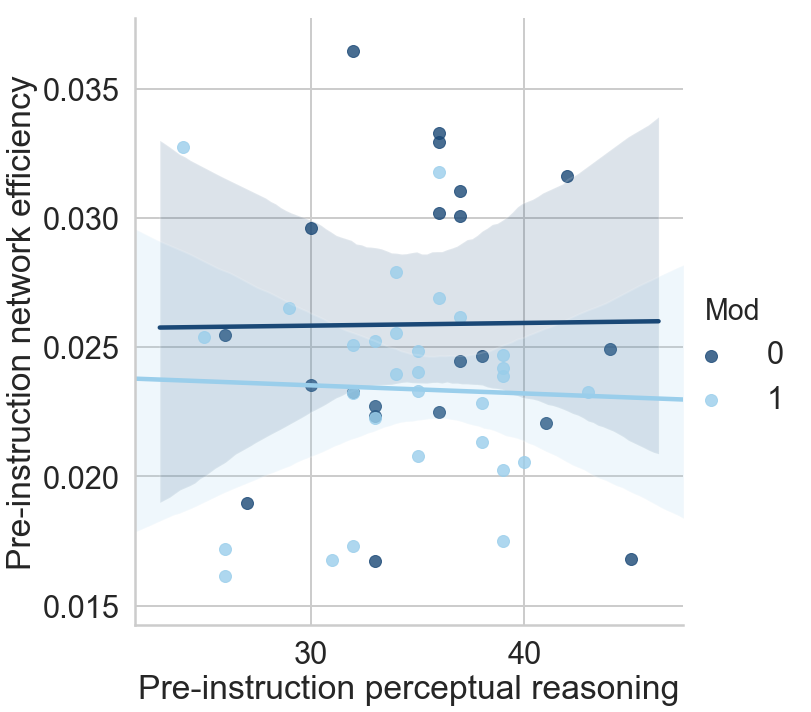

In [69]:
h = sns.lmplot('Perceptual Reasoning Sum_1', 'infr reas shen eff pre', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Pre-instruction perceptual reasoning')
h.set_ylabels('Pre-instruction network efficiency')
h.savefig(join(fig_dir, 'pre_prXpre_eff_inf-m.png'), dpi=300)

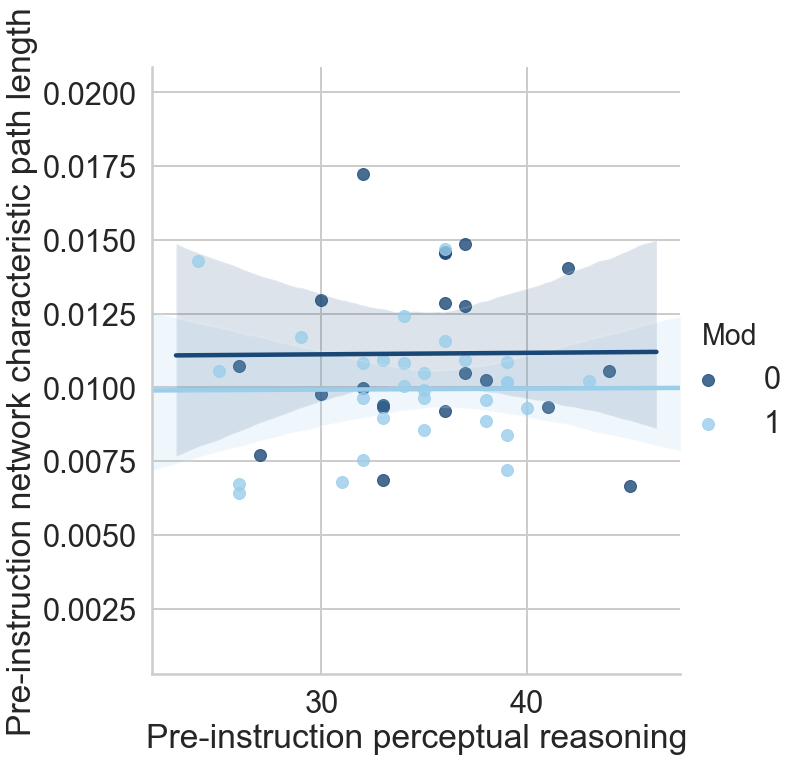

In [70]:
h = sns.lmplot('Perceptual Reasoning Sum_1', 'infr reas shen cpl pre', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Pre-instruction perceptual reasoning')
h.set_ylabels('Pre-instruction network characteristic path length')
h.savefig(join(fig_dir, 'pre_prXpre_cpl_inf-m.png'), dpi=300)

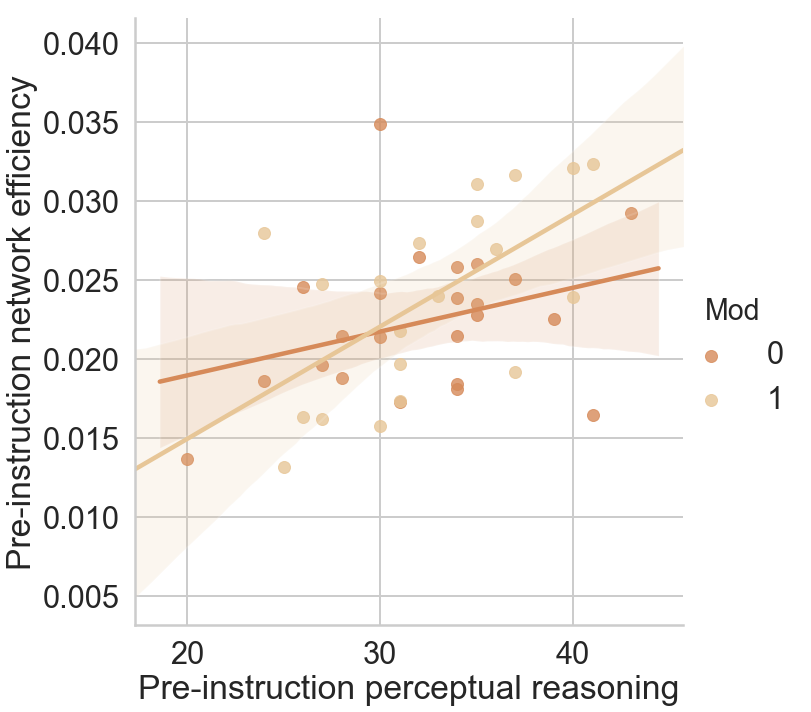

In [71]:
h = sns.lmplot('Perceptual Reasoning Sum_1', 'infr reas shen eff pre', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Pre-instruction perceptual reasoning')
h.set_ylabels('Pre-instruction network efficiency')
h.savefig(join(fig_dir, 'pre_prXpre_eff_inf-f.png'), dpi=300)

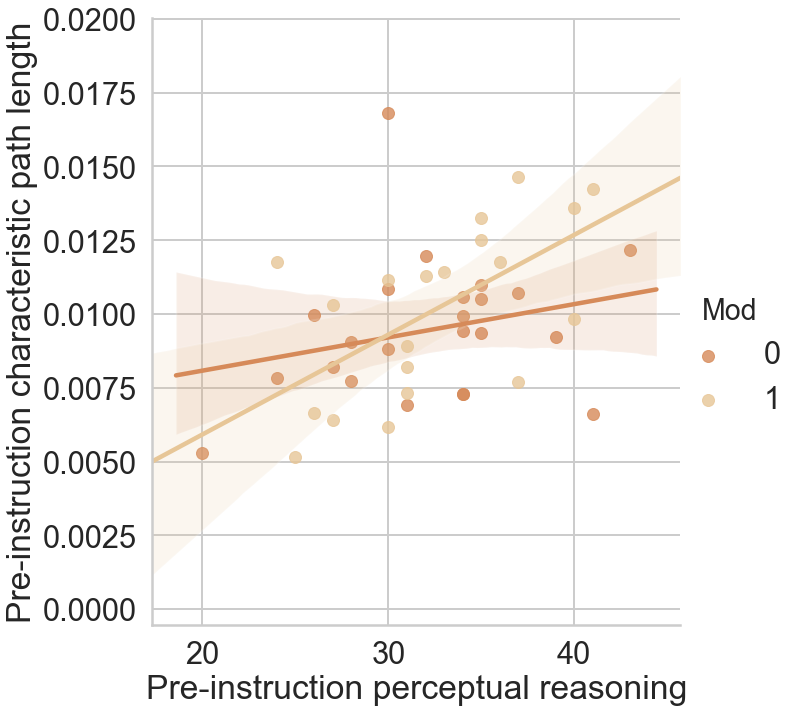

In [72]:
h = sns.lmplot('Perceptual Reasoning Sum_1', 'infr reas shen cpl pre', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Pre-instruction perceptual reasoning')
h.set_ylabels('Pre-instruction characteristic path length')
h.savefig(join(fig_dir, 'pre_prXpre_cpl_inf-f.png'), dpi=300)

In [73]:
#let's use regressions instead
index = pd.MultiIndex.from_product((sessions, iqs))
female_iqXgrade = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)', 
                                                     'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval'])
male_iqXgrade = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)',
                                                   'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval'])

female_mc_alpha,_ = liji_sidak_mc(df_f[outcomes], 0.05)
male_mc_alpha,_ = liji_sidak_mc(df_m[outcomes], 0.05)
for outcome in outcomes:
    for iq_meas in iqs:
        y = df_f[outcome]
        x = df_f[['{0}_1'.format(iq_meas), '{0}_1XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_pre_iq = reg1.fit()
        female_iqXgrade.at[('pre', iq_meas), 'F-statistic'] = grade_on_pre_iq.fvalue
        female_iqXgrade.at[('pre', iq_meas), 'Prob (F-statistic)'] = grade_on_pre_iq.f_pvalue
        if grade_on_pre_iq.f_pvalue < 0.01:
            print('f', outcome, iq_meas, 'p(model) =', grade_on_pre_iq.f_pvalue, 
                  'p(iq_pre) =', grade_on_pre_iq.pvalues[1], 'p(iqXclass) =', grade_on_pre_iq.pvalues[2])
        female_iqXgrade.at[('pre', iq_meas), 'AIC'] = grade_on_pre_iq.aic
        female_iqXgrade.at[('pre', iq_meas), 'BIC'] = grade_on_pre_iq.bic
        female_iqXgrade.at[('pre', iq_meas), 'IQ_pval'] = grade_on_pre_iq.pvalues[1] 
        female_iqXgrade.at[('pre', iq_meas), 'IQXClass_pval'] = grade_on_pre_iq.pvalues[2]
        #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())

        x = df_f[['{0}_2'.format(iq_meas), '{0}_2XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_post_iq = reg1.fit()
        female_iqXgrade.at[('post', iq_meas), 'F-statistic'] = grade_on_post_iq.fvalue
        female_iqXgrade.at[('post', iq_meas), 'Prob (F-statistic)'] = grade_on_post_iq.f_pvalue
        if grade_on_post_iq.f_pvalue < 0.01:
            print('f', outcome, iq_meas, 'p(model) =', grade_on_post_iq.f_pvalue, 
                  'p(iq_post) =', grade_on_post_iq.pvalues[1], 'p(iqXclass) =', grade_on_post_iq.pvalues[2])
        female_iqXgrade.at[('post', iq_meas), 'AIC'] = grade_on_post_iq.aic
        female_iqXgrade.at[('post', iq_meas), 'BIC'] = grade_on_post_iq.bic
        female_iqXgrade.at[('post', iq_meas), 'IQ_pval'] = grade_on_post_iq.pvalues[1]
        female_iqXgrade.at[('post', iq_meas), 'IQXClass_pval'] = grade_on_post_iq.pvalues[2]
        #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())
        if iq_meas == 'Full Scale IQ':
            x = df_f[['delta {0}'.format(iq_meas), 'delta {0}XClass'.format(iq_meas)] + covariates]
        else:
            x = df_f[['delta {0}'.format(iq_meas[:-4]), 'delta {0}XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_delta_iq = reg1.fit()
        female_iqXgrade.at[('delta', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
        female_iqXgrade.at[('delta', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
        female_iqXgrade.at[('delta', iq_meas), 'AIC'] = grade_on_delta_iq.aic
        female_iqXgrade.at[('delta', iq_meas), 'BIC'] = grade_on_delta_iq.bic
        female_iqXgrade.at[('delta', iq_meas), 'IQ_pval'] = grade_on_delta_iq.pvalues[1]
        female_iqXgrade.at[('delta', iq_meas), 'IQXClass_pval'] = grade_on_delta_iq.pvalues[2]
        if grade_on_delta_iq.f_pvalue < 0.01:
            print('f', outcome, iq_meas, 'p(model) =', grade_on_delta_iq.f_pvalue, 
                  'p(iq_delta) =', grade_on_delta_iq.pvalues[1], 'p(iqXclass) =', grade_on_delta_iq.pvalues[2])
        
        y = df_m[outcome]
        x = df_m[['{0}_1'.format(iq_meas), '{0}_1XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_pre_iq = reg1.fit()
        male_iqXgrade.at[('pre', iq_meas), 'F-statistic'] = grade_on_pre_iq.fvalue
        male_iqXgrade.at[('pre', iq_meas), 'Prob (F-statistic)'] = grade_on_pre_iq.f_pvalue
        male_iqXgrade.at[('pre', iq_meas), 'AIC'] = grade_on_pre_iq.aic
        male_iqXgrade.at[('pre', iq_meas), 'BIC'] = grade_on_pre_iq.bic
        male_iqXgrade.at[('pre', iq_meas), 'IQ_pval'] = grade_on_pre_iq.pvalues[1]
        male_iqXgrade.at[('pre', iq_meas), 'IQXClass_pval'] = grade_on_pre_iq.pvalues[2]
        #print('Course grade regressed on pre IQ, male students\n', grade_on_iq.summary())
        if grade_on_pre_iq.f_pvalue < male_mc_alpha:
            print('m', outcome, iq_meas, 'p(model) =', grade_on_pre_iq.f_pvalue, 
                  'p(iq_pre) =', grade_on_pre_iq.pvalues[1], 'p(iqXclass) =', grade_on_pre_iq.pvalues[2])

        x = df_m[['{0}_2'.format(iq_meas), '{0}_2XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_post_iq = reg1.fit()
        male_iqXgrade.at[('post', iq_meas), 'F-statistic'] = grade_on_post_iq.fvalue
        male_iqXgrade.at[('post', iq_meas), 'Prob (F-statistic)'] = grade_on_post_iq.f_pvalue
        male_iqXgrade.at[('post', iq_meas), 'AIC'] = grade_on_post_iq.aic
        male_iqXgrade.at[('post', iq_meas), 'BIC'] = grade_on_post_iq.bic
        male_iqXgrade.at[('post', iq_meas), 'IQ_pval'] = grade_on_post_iq.pvalues[1]
        male_iqXgrade.at[('post', iq_meas), 'IQXClass_pval'] = grade_on_post_iq.pvalues[2]
        if grade_on_post_iq.f_pvalue < male_mc_alpha:
            print('m', outcome, iq_meas, 'p(model) =', grade_on_post_iq.f_pvalue, 
                  'p(iq_post) =', grade_on_post_iq.pvalues[1], 'p(iqXclass) =', grade_on_post_iq.pvalues[2])
        #print('Course grade regressed on post IQ, male students\n', grade_on_iq.summary())
        if iq_meas == 'Full Scale IQ':
            x = df_m[['delta {0}'.format(iq_meas), 'delta {0}XClass'.format(iq_meas)] + covariates]
        else:
            x = df_m[['delta {0}'.format(iq_meas[:-4]), 'delta {0}XClass'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        grade_on_delta_iq = reg1.fit()
        male_iqXgrade.at[('delta', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
        male_iqXgrade.at[('delta', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
        male_iqXgrade.at[('delta', iq_meas), 'AIC'] = grade_on_delta_iq.aic
        male_iqXgrade.at[('delta', iq_meas), 'BIC'] = grade_on_delta_iq.bic
        male_iqXgrade.at[('delta', iq_meas), 'IQ_pval'] = grade_on_delta_iq.pvalues[1]
        male_iqXgrade.at[('delta', iq_meas), 'IQXClass_pval'] = grade_on_delta_iq.pvalues[2]
        #print('Course grade regressed on delta IQ, female students\n', grade_on_iq.summary())
        if grade_on_delta_iq.f_pvalue < male_mc_alpha:
            print('m', outcome, iq_meas, 'p(model) =', grade_on_delta_iq.f_pvalue, 
                  'p(iq_delta) =', grade_on_delta_iq.pvalues[1], 'p(iqXclass) =', grade_on_delta_iq.pvalues[2])
    female_iqXgrade.to_csv(join(data_dir, 'iqX{0}_female.csv'.format(outcome)))
    male_iqXgrade.to_csv(join(data_dir, 'iqX{0}_male.csv'.format(outcome)))

Number of effective comparisons: 8.015297502219337
Critical value of 0.050 becomes 0.006379 after corrections
Number of effective comparisons: 8.37091958469061
Critical value of 0.050 becomes 0.006109 after corrections
f infr reas shen eff post Working Memory Sum p(model) = 0.00676370224329606 p(iq_pre) = 0.0002588709085280219 p(iqXclass) = 0.0007106266655361733
f infr reas shen cpl post Working Memory Sum p(model) = 0.009299157649311027 p(iq_pre) = 0.00024100593306199987 p(iqXclass) = 0.0006932253093838852
m infr reas shen eff delta Verbal Comprehension Sum p(model) = 0.002486601311245855 p(iq_delta) = 0.6109643537961824 p(iqXclass) = 0.5707451648793334
m infr reas shen eff delta Working Memory Sum p(model) = 0.0017496190673956897 p(iq_pre) = 0.024883498449138893 p(iqXclass) = 0.004411719357506015
m infr reas shen cpl delta Verbal Comprehension Sum p(model) = 0.00525768893917638 p(iq_delta) = 0.5569109735579758 p(iqXclass) = 0.6986247886533837
m infr reas shen cpl delta Working Memory

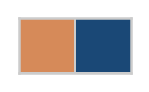

In [74]:
sns.palplot(crayons_d)

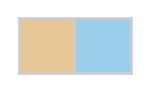

In [75]:
sns.palplot(crayons_l)

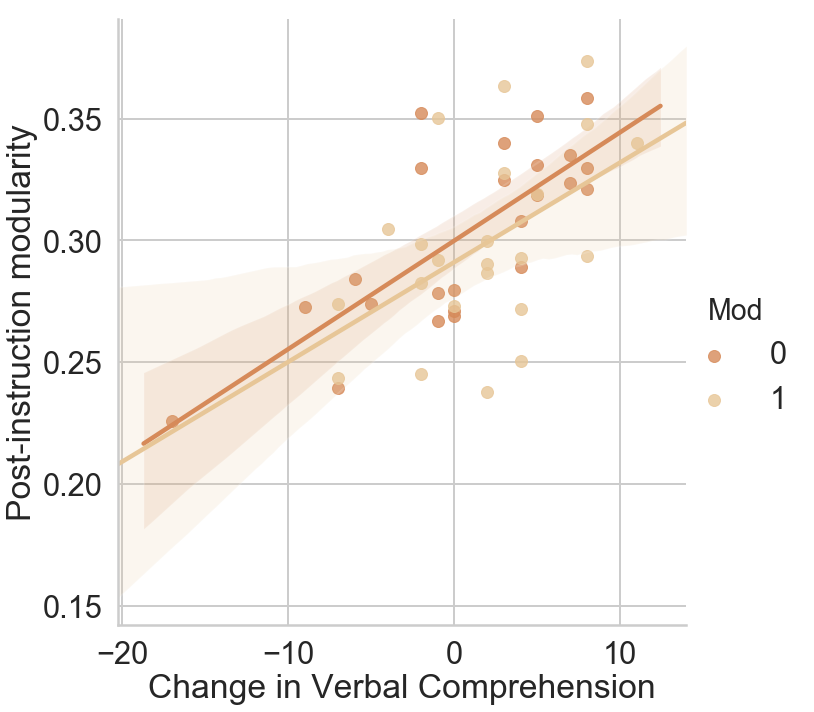

In [76]:
#plot some plots
k = sns.lmplot('delta Verbal Comprehension', 'crad mod post', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)
k.set_xlabels('Change in Verbal Comprehension')
k.set_ylabels('Post-instruction modularity')
k.savefig(join(fig_dir, 'delta_vcXpost_mod_rest-f.png'), dpi=300)

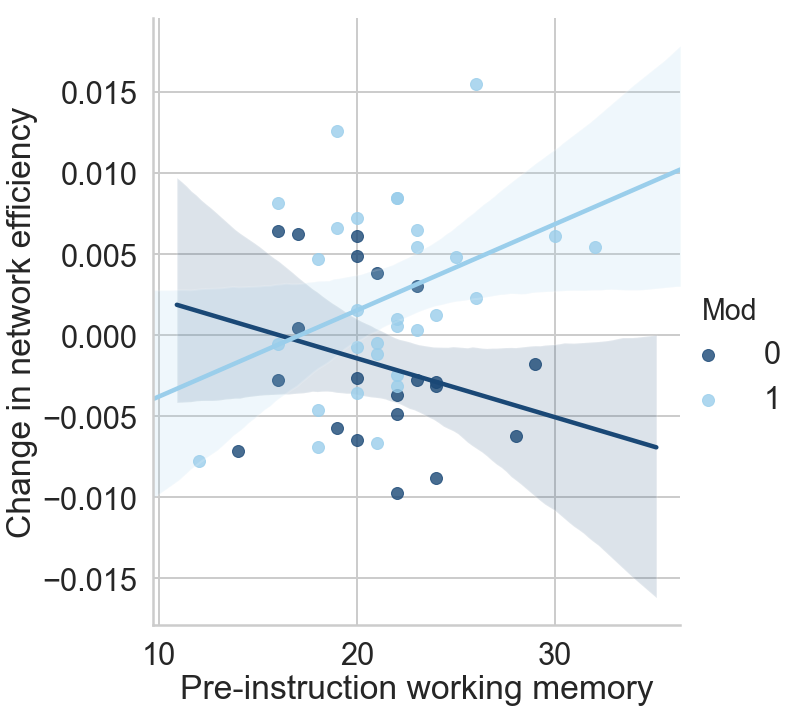

In [77]:
h = sns.lmplot('Working Memory Sum_1', 'infr reas shen eff delta', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Pre-instruction working memory')
h.set_ylabels('Change in network efficiency')
h.savefig(join(fig_dir, 'pre_wmXdelta_eff_inf-m.png'), dpi=300)

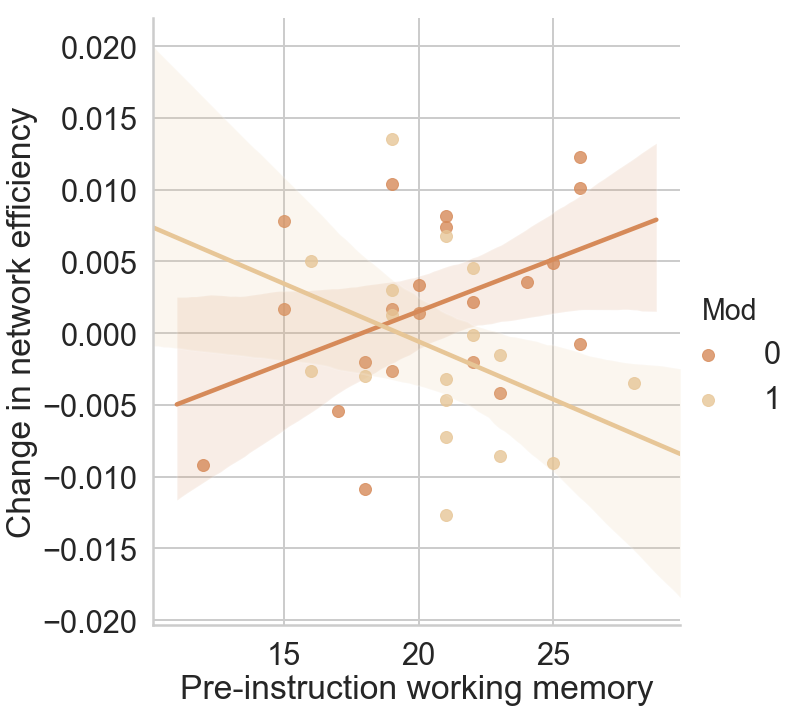

In [78]:
h = sns.lmplot('Working Memory Sum_1', 'infr reas shen eff delta', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Pre-instruction working memory')
h.set_ylabels('Change in network efficiency')
h.savefig(join(fig_dir, 'pre_wmXdelta_eff_inf-f.png'), dpi=300)

<Figure size 432x288 with 0 Axes>

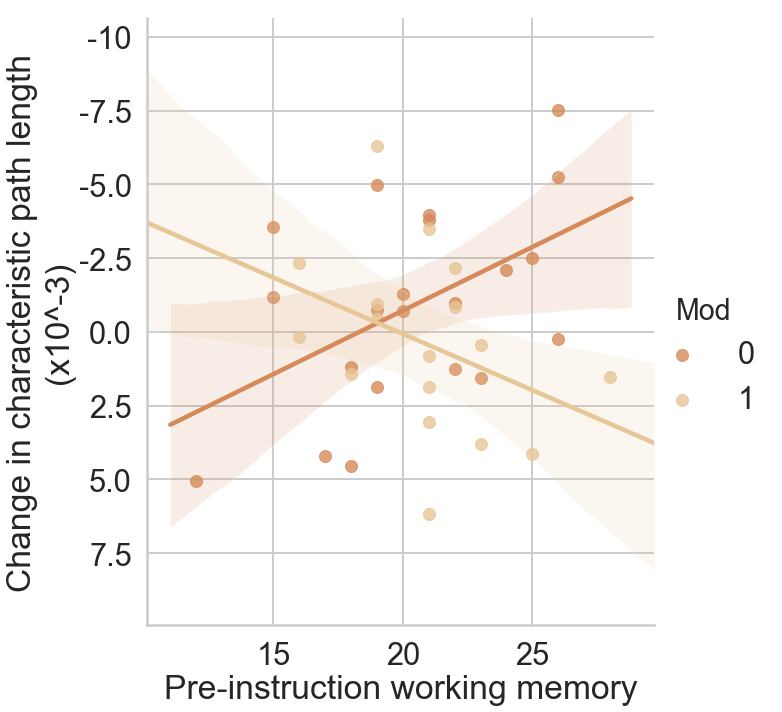

In [79]:
plt.tight_layout(pad=2)
g = sns.lmplot('Working Memory Sum_1', 'infr reas shen cpl delta', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)
g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Pre-instruction working memory')
g.set_ylabels('Change in characteristic path length\n(x10^-3)')
g.savefig(join(fig_dir, 'pre_wmXdelta_cpl_inf-f.png'), dpi=300)

<Figure size 432x288 with 0 Axes>

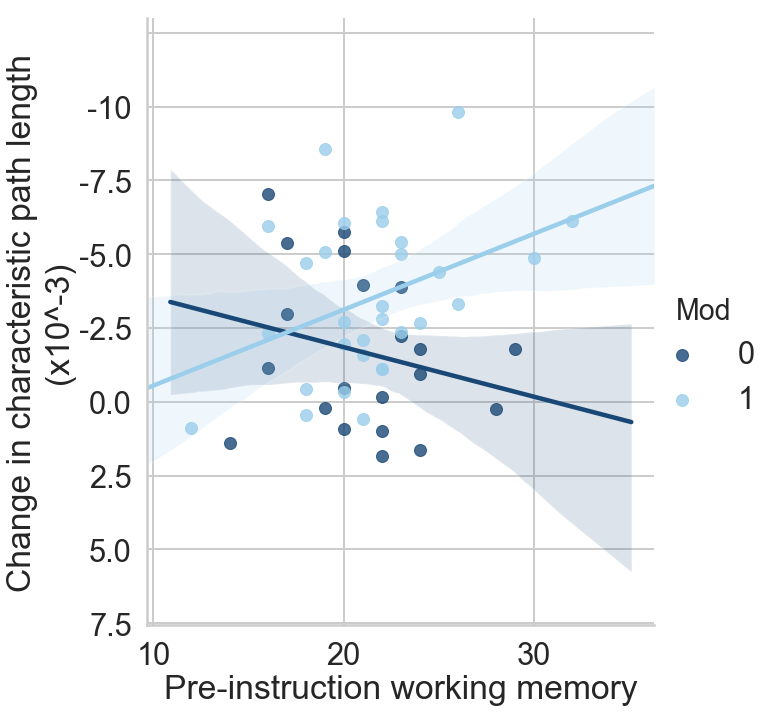

In [80]:
plt.tight_layout(pad=2)
g = sns.lmplot('Working Memory Sum_1', 'infr reas shen cpl delta', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)
g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Pre-instruction working memory')
g.set_ylabels('Change in characteristic path length\n(x10^-3)')
g.savefig(join(fig_dir, 'pre_wmXdelta_cpl_inf-m.png'), dpi=300)

In [81]:
df_m.keys()[:20]

Index(['AgeOnScanDate', 'Phy48Grade', 'GPA.PreSem',
       'Mean Physics Retrieval Accuracy Pre', 'Mean Correct RT Pre',
       'Mean Incorrect RT Pre', 'Mean Physics Retrieval Accuracy Post',
       'Mean Correct RT Post', 'Mean Incorrect RT Post', 'Gender', 'Class',
       'Pre Mean FCI Accuracy', 'Post Mean FCI Accuracy', 'shen eff pre',
       'shen eff post', 'shen cpl pre', 'shen cpl post', 'shen mod pre',
       'shen mod post', 'crad eff pre'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

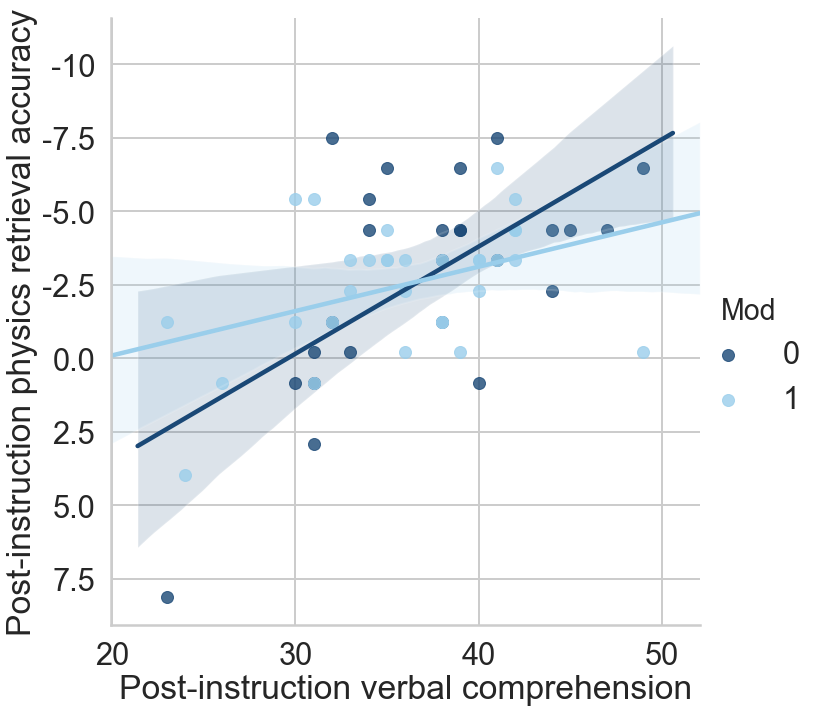

In [82]:
plt.tight_layout(pad=2)
g = sns.lmplot('Verbal Comprehension Sum_2', 'Mean Physics Retrieval Accuracy Post', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)
g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Post-instruction verbal comprehension')
g.set_ylabels('Post-instruction physics retrieval accuracy')
g.savefig(join(fig_dir, 'post_vcXpost_retr_acc-m.png'), dpi=300)

In [83]:
fci_df = pd.read_csv(join(data_dir, 'physics-learning-fci_graphtheory_shen+craddock_2019-05-31.csv'), 
                     index_col=0, header=0)


In [84]:
phys_fci = fci_df[fci_df['condition'] == 'high-level']
ctrl_fci = fci_df[fci_df['condition'] == 'lower-level']

In [85]:
#physics fci measures per session per parcellation
df_pivot = phys_fci[phys_fci['mask'] == 'shen2015'].reset_index()
shen_eff_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_phys_fci_df.rename({0: 'phys fci shen eff pre', 1: 'phys fci shen eff post'}, axis=1, inplace=True)

shen_cpl_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_phys_fci_df.rename({0: 'phys fci shen cpl pre', 1: 'phys fci shen cpl post'}, axis=1, inplace=True)

shen_mod_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_phys_fci_df.rename({0: 'phys fci shen mod pre', 1: 'phys fci shen mod post'}, axis=1, inplace=True)

df_pivot = phys_fci[phys_fci['mask'] == 'craddock2012'].reset_index()
crad_eff_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_phys_fci_df.rename({0: 'phys fci crad eff pre', 1: 'phys fci crad eff post'}, axis=1, inplace=True)

crad_cpl_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_phys_fci_df.rename({0: 'phys fci crad cpl pre', 1: 'phys fci crad cpl post'}, axis=1, inplace=True)

crad_mod_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_phys_fci_df.rename({0: 'phys fci crad mod pre', 1: 'phys fci crad mod post'}, axis=1, inplace=True)


#ctrl fci measures per session per parcellation
df_pivot = ctrl_fci[ctrl_fci['mask'] == 'shen2015'].reset_index()
shen_eff_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_ctrl_fci_df.rename({0: 'ctrl fci shen eff pre', 1: 'ctrl fci shen eff post'}, axis=1, inplace=True)

shen_cpl_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_ctrl_fci_df.rename({0: 'ctrl fci shen cpl pre', 1: 'ctrl fci shen cpl post'}, axis=1, inplace=True)

shen_mod_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_ctrl_fci_df.rename({0: 'ctrl fci shen mod pre', 1: 'ctrl fci shen mod post'}, axis=1, inplace=True)

df_pivot = ctrl_fci[ctrl_fci['mask'] == 'craddock2012'].reset_index()
crad_eff_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_ctrl_fci_df.rename({0: 'ctrl fci crad eff pre', 1: 'ctrl fci crad eff post'}, axis=1, inplace=True)

crad_cpl_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_ctrl_fci_df.rename({0: 'ctrl fci crad cpl pre', 1: 'ctrl fci crad cpl post'}, axis=1, inplace=True)

crad_mod_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_ctrl_fci_df.rename({0: 'ctrl fci crad mod pre', 1: 'ctrl fci crad mod post'}, axis=1, inplace=True)

In [86]:
bigger_df = pd.concat((big_df, shen_eff_phys_fci_df, shen_cpl_phys_fci_df, shen_mod_phys_fci_df,
                       crad_eff_phys_fci_df, crad_cpl_phys_fci_df, crad_mod_phys_fci_df), axis=1)
wide_fci_df = pd.concat((shen_eff_phys_fci_df, shen_cpl_phys_fci_df, shen_mod_phys_fci_df,
                       crad_eff_phys_fci_df, crad_cpl_phys_fci_df, crad_mod_phys_fci_df, 
                         shen_eff_ctrl_fci_df, shen_cpl_ctrl_fci_df, shen_mod_ctrl_fci_df,
                      crad_eff_ctrl_fci_df, crad_cpl_ctrl_fci_df, crad_mod_ctrl_fci_df), axis=1)

In [87]:
wide_fci_df.columns

Index(['phys fci shen eff pre', 'phys fci shen eff post',
       'phys fci shen cpl pre', 'phys fci shen cpl post',
       'phys fci shen mod pre', 'phys fci shen mod post',
       'phys fci crad eff pre', 'phys fci crad eff post',
       'phys fci crad cpl pre', 'phys fci crad cpl post',
       'phys fci crad mod pre', 'phys fci crad mod post',
       'ctrl fci shen eff pre', 'ctrl fci shen eff post',
       'ctrl fci shen cpl pre', 'ctrl fci shen cpl post',
       'ctrl fci shen mod pre', 'ctrl fci shen mod post',
       'ctrl fci crad eff pre', 'ctrl fci crad eff post',
       'ctrl fci crad cpl pre', 'ctrl fci crad cpl post',
       'ctrl fci crad mod pre', 'ctrl fci crad mod post'],
      dtype='object', name='session')

In [88]:
outcomes = ['phys fci shen eff pre', 'phys fci shen eff post', 
            'phys fci shen cpl pre', 'phys fci shen cpl post',
            'phys fci shen mod pre', 'phys fci shen mod post',
            'ctrl fci shen eff pre', 'ctrl fci shen eff post', 
            'ctrl fci shen cpl pre', 'ctrl fci shen cpl post',
            'ctrl fci shen mod pre', 'ctrl fci shen mod post']

In [89]:
mc_alpha,_ = liji_sidak_mc(wide_fci_df, 0.05)

Number of effective comparisons: 7.726795534579785
Critical value of 0.050 becomes 0.006616 after corrections


In [90]:
yikes = pd.concat((wide_fci_df, all_df['']), )
for iq_meas in iqs:
    yikes = pd.concat((yikes, bigger_df[['{0}_1'.format(iq_meas), 
                    '{0}_1XClass'.format(iq_meas), 
                    'SexXClass',
                    '{0}_1XSex'.format(iq_meas),
                    '{0}_1XClassXSex'.format(iq_meas)]]), axis=1)
    if iq_meas == 'Full Scale IQ':
        yikes = pd.concat((yikes, bigger_df[['delta {0}'.format(iq_meas), 
                    'delta {0}XClass'.format(iq_meas), 
                    'delta {0}XSex'.format(iq_meas),
                    'delta {0}XClassXSex'.format(iq_meas)]]), axis=1)
    else:
        yikes = pd.concat((yikes, bigger_df[['delta {0}'.format(iq_meas[:-4]), 
                    'delta {0}XClass'.format(iq_meas), 
                    'delta {0}XSex'.format(iq_meas),
                    'delta {0}XClassXSex'.format(iq_meas)]]), axis=1)

KeyError: ''

In [ ]:
index = pd.MultiIndex.from_product((sessions, iqs))
brain_iqXclassXsex = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)',
                                                        'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval', 
                                                        'IQXClass_pval', 'SexXClass_pval', 'IQXSex_pval', 
                                                        'IQXClassXSex_pval'])
mc_alpha,_ = liji_sidak_mc(yikes[outcomes], 0.05)

for outcome in outcomes:
    for iq_meas in iqs:
        y = yikes[outcome]
        x = yikes[['{0}_1'.format(iq_meas), 
                    '{0}_1XClass'.format(iq_meas), 
                    'SexXClass',
                    '{0}_1XSex'.format(iq_meas),
                    '{0}_1XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_pre_iq = reg1.fit()
        brain_iqXclassXsex.loc[('pre', iq_meas), 'F-statistic'] = brain_on_pre_iq.fvalue
        brain_iqXclassXsex.loc[('pre', iq_meas), 'Prob (F-statistic)'] = brain_on_pre_iq.f_pvalue
        brain_iqXclassXsex.loc[('pre', iq_meas), 'AIC'] = brain_on_pre_iq.aic
        brain_iqXclassXsex.loc[('pre', iq_meas), 'BIC'] = brain_on_pre_iq.bic
        brain_iqXclassXsex.loc[('pre', iq_meas), 'IQ_pval'] = brain_on_pre_iq.pvalues[1] 
        brain_iqXclassXsex.loc[('pre', iq_meas), 'IQXClass_pval'] = brain_on_pre_iq.pvalues[2]
        brain_iqXclassXsex.loc[('pre', iq_meas), 'SexXClass_pval'] = brain_on_pre_iq.pvalues[3]
        brain_iqXclassXsex.loc[('pre', iq_meas), 'IQXSex_pval'] = brain_on_pre_iq.pvalues[4]
        brain_iqXclassXsex.loc[('pre', iq_meas), 'IQXClassXSex_pval'] = brain_on_pre_iq.pvalues[5]
        #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())
        if brain_on_pre_iq.f_pvalue < mc_alpha:
            print('all students', outcome, iq_meas, 'p(model) =', brain_on_pre_iq.f_pvalue, 
                  'p(iq_pre) =', brain_on_pre_iq.pvalues[1], 'p(iqXclass) =', brain_on_pre_iq.pvalues[2])

        x = yikes[['{0}_2'.format(iq_meas), 
                    '{0}_2XClass'.format(iq_meas), 
                    'SexXClass',
                    '{0}_2XSex'.format(iq_meas),
                    '{0}_2XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_post_iq = reg1.fit()
        brain_iqXclassXsex.loc[('post', iq_meas), 'F-statistic'] = brain_on_post_iq.fvalue
        brain_iqXclassXsex.loc[('post', iq_meas), 'Prob (F-statistic)'] = brain_on_post_iq.f_pvalue
        brain_iqXclassXsex.loc[('post', iq_meas), 'AIC'] = brain_on_post_iq.aic
        brain_iqXclassXsex.loc[('post', iq_meas), 'BIC'] = brain_on_post_iq.bic
        brain_iqXclassXsex.loc[('post', iq_meas), 'IQ_pval'] = brain_on_post_iq.pvalues[1] 
        brain_iqXclassXsex.loc[('post', iq_meas), 'IQXClass_pval'] = brain_on_post_iq.pvalues[2]
        brain_iqXclassXsex.loc[('post', iq_meas), 'SexXClass_pval'] = brain_on_post_iq.pvalues[3]
        brain_iqXclassXsex.loc[('post', iq_meas), 'IQXSex_pval'] = brain_on_post_iq.pvalues[4]
        brain_iqXclassXsex.loc[('post', iq_meas), 'IQXClassXSex_pval'] = brain_on_post_iq.pvalues[5]
        #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())
        if brain_on_post_iq.f_pvalue < mc_alpha:
            print('all students', outcome, iq_meas, 'p(model) =', brain_on_post_iq.f_pvalue, 
                  'p(iq_post) =', brain_on_post_iq.pvalues[1], 'p(iqXclass) =', brain_on_post_iq.pvalues[2])
            
        if iq_meas == 'Full Scale IQ':
            x = yikes[['delta {0}'.format(iq_meas), 
                        'delta {0}XClass'.format(iq_meas), 
                        'SexXClass', 
                        'delta {0}XSex'.format(iq_meas),
                        'delta {0}XClassXSex'.format(iq_meas)] + covariates]
        else:
            x = yikes[['delta {0}'.format(iq_meas[:-4]), 
                        'delta {0}XClass'.format(iq_meas), 
                        'SexXClass', 
                        'delta {0}XSex'.format(iq_meas),
                        'delta {0}XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_delta_iq = reg1.fit()
        brain_iqXclassXsex.loc[('delta', iq_meas), 'F-statistic'] = brain_on_delta_iq.fvalue
        brain_iqXclassXsex.loc[('delta', iq_meas), 'Prob (F-statistic)'] = brain_on_delta_iq.f_pvalue
        brain_iqXclassXsex.loc[('delta', iq_meas), 'AIC'] = brain_on_delta_iq.aic
        brain_iqXclassXsex.loc[('delta', iq_meas), 'BIC'] = brain_on_delta_iq.bic
        brain_iqXclassXsex.loc[('delta', iq_meas), 'IQ_pval'] = brain_on_delta_iq.pvalues[1]
        brain_iqXclassXsex.loc[('delta', iq_meas), 'IQXClass_pval'] = brain_on_delta_iq.pvalues[2]
        brain_iqXclassXsex.loc[('delta', iq_meas), 'SexXClass_pval'] = brain_on_delta_iq.pvalues[3]
        brain_iqXclassXsex.loc[('delta', iq_meas), 'IQXSex_pval'] = brain_on_delta_iq.pvalues[4]
        brain_iqXclassXsex.loc[('delta', iq_meas), 'IQXClassXSex_pval'] = brain_on_delta_iq.pvalues[3]
        if brain_on_delta_iq.f_pvalue < mc_alpha:
            print('all students', outcome, iq_meas, 'p(model) =', brain_on_delta_iq.f_pvalue, 
                  'p(iq_delta) =', brain_on_delta_iq.pvalues[1], 'p(iqXclass) =', brain_on_delta_iq.pvalues[2])
    brain_iqXclassXsex.to_csv(join(data_dir, 'iqXfci{0}Xsex_all.csv'.format(outcome)))

In [ ]:
yikes.columns